# Análisis exploratorio de la base de datos


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sqlalchemy import create_engine
from sqlalchemy import text
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import pandas as pd
import shap

from files.data_processing import process_data
from files.process_users import process_user_data
from files.process_purchase import process_purchase_events
from files.process_add import process_add_to_cart_events

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
db_user = ***********
db_password = **********
db_host = *********
db_port = "5432"  # Puerto por defecto de PostgreSQL
db_name = "postgres"

engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

with engine.connect() as connection:
    connection.execute(text("SET statement_timeout = 8000000;"))
    df = pd.read_sql("SELECT * FROM datatg.eventos_notnull", connection)


Veamos la estructura de la base de datos en crudo:


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

print(df.shape)
print(df.info())

(317056, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317056 entries, 0 to 317055
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   event_date                         317056 non-null  object 
 1   event_timestamp                    317056 non-null  int64  
 2   event_name                         317056 non-null  object 
 3   event_params                       317056 non-null  object 
 4   event_bundle_sequence_id           317056 non-null  int64  
 5   user_pseudo_id                     197760 non-null  object 
 6   privacy_info                       317056 non-null  object 
 7   user_first_touch_timestamp         314559 non-null  float64
 8   user_ltv                           7261 non-null    object 
 9   device                             317056 non-null  object 
 10  geo                                317056 non-null  object 
 11  traffic_source            

Aplicamos el procesamiento de datos del módulo 'data_processing'.

In [5]:
df_processed = process_data(df)
print(df_processed.shape)
df_processed.info()

(317056, 29)
<class 'pandas.core.frame.DataFrame'>
Index: 317056 entries, 45518 to 10546
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype          
---  ------                             --------------   -----          
 0   event_date                         317056 non-null  object         
 1   event_timestamp                    317056 non-null  datetime64[ns] 
 2   event_name                         317056 non-null  object         
 3   event_params                       317056 non-null  object         
 4   event_bundle_sequence_id           317056 non-null  int64          
 5   user_pseudo_id                     197760 non-null  object         
 6   privacy_info                       317056 non-null  object         
 7   user_first_touch_timestamp         314559 non-null  datetime64[ns] 
 8   user_ltv                           7261 non-null    object         
 9   device                             317056 non-null  object         
 1

In [6]:
df_processed.head()

,event_date,event_timestamp,event_name,event_params,event_bundle_sequence_id,user_pseudo_id,privacy_info,user_first_touch_timestamp,user_ltv,device,...,time_difference,city,country,num_views,num_clicks,num_engagement,num_scrolls,num_events,disp,brand
45518,20241201,2024-11-30 23:01:09.762,user_engagement,"{""v"":[{""v"":{""f"":[{""v"":""batch_ordering_id""},{""v...",1250727993,None,"{""v"":{""f"":[{""v"":""No""},{""v"":""No""},{""v"":""No""}]}}",NaT,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Samsung""},{""v""...",...,0 days 00:00:00,Dublin,Ireland,NaN,NaN,NaN,NaN,NaN,mobile,Samsung
45493,20241201,2024-11-30 23:01:49.199,page_view,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1290165517,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:43.475000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
50265,20241201,2024-11-30 23:01:50.203,scroll,"{""v"":[{""v"":{""f"":[{""v"":""page_location""},{""v"":{""...",1291169772,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:44.479000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
307911,20241201,2024-11-30 23:01:54.209,view_item_list,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1295175373,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:48.485000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
164667,20241201,2024-11-30 23:01:59.211,FID,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1300177485,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:53.487000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi


Eliminamos todos los registros donde el id de usuario es nulo.

In [7]:
df_processed = df_processed[df_processed['user_pseudo_id'].notna()]
print(df_processed.shape)
df_processed.head()

(197760, 29)


,event_date,event_timestamp,event_name,event_params,event_bundle_sequence_id,user_pseudo_id,privacy_info,user_first_touch_timestamp,user_ltv,device,...,time_difference,city,country,num_views,num_clicks,num_engagement,num_scrolls,num_events,disp,brand
45493,20241201,2024-11-30 23:01:49.199,page_view,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1290165517,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:43.475000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
50265,20241201,2024-11-30 23:01:50.203,scroll,"{""v"":[{""v"":{""f"":[{""v"":""page_location""},{""v"":{""...",1291169772,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:44.479000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
307911,20241201,2024-11-30 23:01:54.209,view_item_list,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1295175373,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:48.485000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
164667,20241201,2024-11-30 23:01:59.211,FID,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1300177485,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:00:53.487000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi
265205,20241201,2024-11-30 23:02:19.718,INP,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",1320684632,1307396168.1733007666,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-30 23:01:05.724,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Xiaomi""},{""v"":...",...,0 days 00:01:13.994000,,Spain,2.0,0.0,0.0,1.0,10.0,mobile,Xiaomi


Se muestra un histograma de la distribución de eventos por países.

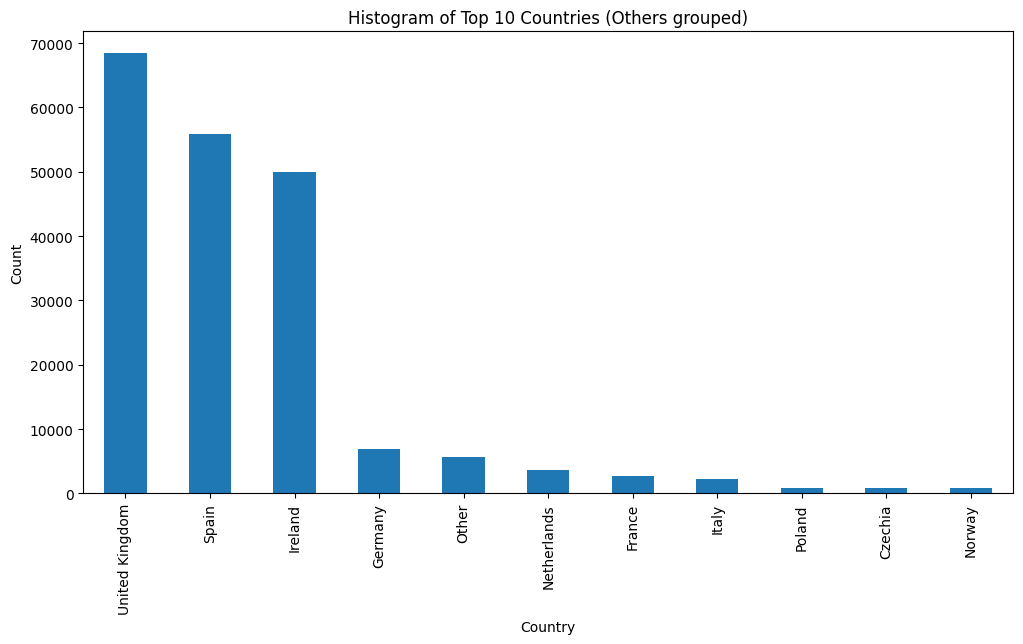

In [8]:
top_countries = df_processed['country'].value_counts().nlargest(10).index
df_processed['country_grouped'] = df_processed['country'].where(df_processed['country'].isin(top_countries), 'Other')
df_processed['country_grouped'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Histogram of Top 10 Countries (Others grouped)')
plt.show()

In [9]:
print("Número de eventos por categoría:\n",  df_processed['event_name'].value_counts())

Número de eventos por categoría:
 event_name
page_view                        51883
user_engagement                  36718
scroll                           16596
view_item_list                   15608
session_start                    13969
LCP                              13858
CLS                              13592
first_visit                       9842
FID                               7620
INP                               7615
no_availability                   5344
loyalty                            810
add_to_cart                        799
view_search_results                689
begin_checkout                     584
click                              521
occupancy_change                   259
add_shipping_info                  248
confirmation_attempt               192
purchase                           167
remove_from_cart                   145
confirm_after_pending_attempt      129
origin_booking                     129
login                              121
login_error        

Mirando estos números, podemos ver como representan a la perfección el embudo de conversión, veamoslo con mayor claridad.


In [10]:
import plotly.graph_objects as go

conversion_steps = ['page_view', 'view_item_list', 'add_to_cart', 'purchase']

funnel = df[df['event_name'].isin(conversion_steps)]
funnel_counts = funnel['event_name'].value_counts().reindex(conversion_steps)

fig = go.Figure(go.Funnel(
    y=conversion_steps,
    x=funnel_counts.values,
    textinfo="value+percent previous",
    marker=dict(color=['#69b3a2', '#437c90', '#f4a261', '#e76f51'])
))

fig.update_layout(title='Funnel de Conversión de Usuarios')
fig.show()

Vemos claramente como la tasa de conversión entre las visitas y las compras es muy baja como es de esperar, cercana al 0,2%.

Despues de explorar esta base de datos también manualmente, se ve claramente como hay muchas columnas con poca información, o muy poco relevante y difícil de interpretar, así que con la vista puesta en pasar dicha base de datos 3 forma normal, primero haremos una tabla con la información de los usuarios.

In [11]:
df_users = process_user_data(df_processed)
print(df_users.shape)
print(df_users.info())


c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_users.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_users.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_users.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(11476, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11476 entries, 0 to 11475
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_pseudo_id            11476 non-null  object        
 1   city                      11476 non-null  object        
 2   country                   11476 non-null  object        
 3   disp                      11476 non-null  object        
 4   brand                     11476 non-null  object        
 5   purchase                  11476 non-null  bool          
 6   no_availability           11476 non-null  bool          
 7   refund                    11476 non-null  bool          
 8   add_to_cart               11476 non-null  bool          
 9   num_views                 11476 non-null  float64       
 10  num_events                11476 non-null  float64       
 11  num_engagement            11476 non-null  float64       
 12  num_sc

In [12]:
df_users.head()

,user_pseudo_id,city,country,disp,brand,purchase,no_availability,refund,add_to_cart,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date
0,1000075147.1736646133,Puerto del Carmen,Spain,mobile,Unknown,False,True,False,False,8.0,38.0,2.0,4.0,19665.369,2025-01-12,2025-01-12
1,1000409496.1736677314,Limerick,Ireland,desktop,Google,False,True,False,False,20.0,96.0,11.0,13.0,48682.067,2025-01-12,2025-01-13
2,1000410660.1734943681,Madrid,Spain,mobile,Xiaomi,False,True,False,False,5.0,18.0,3.0,2.0,72.748,2024-12-23,2024-12-23
3,1000560983.1733155660,Mallow,Ireland,desktop,Apple,False,False,False,False,1.0,2.0,1.0,0.0,0.000,2024-12-02,2024-12-02
4,1000661678.1734282826,Dagenham,United Kingdom,mobile,Apple,False,False,False,False,1.0,5.0,2.0,0.0,9.020,2024-12-15,2024-12-15


Se muestra un histograma con la distribución de usuarios por país.

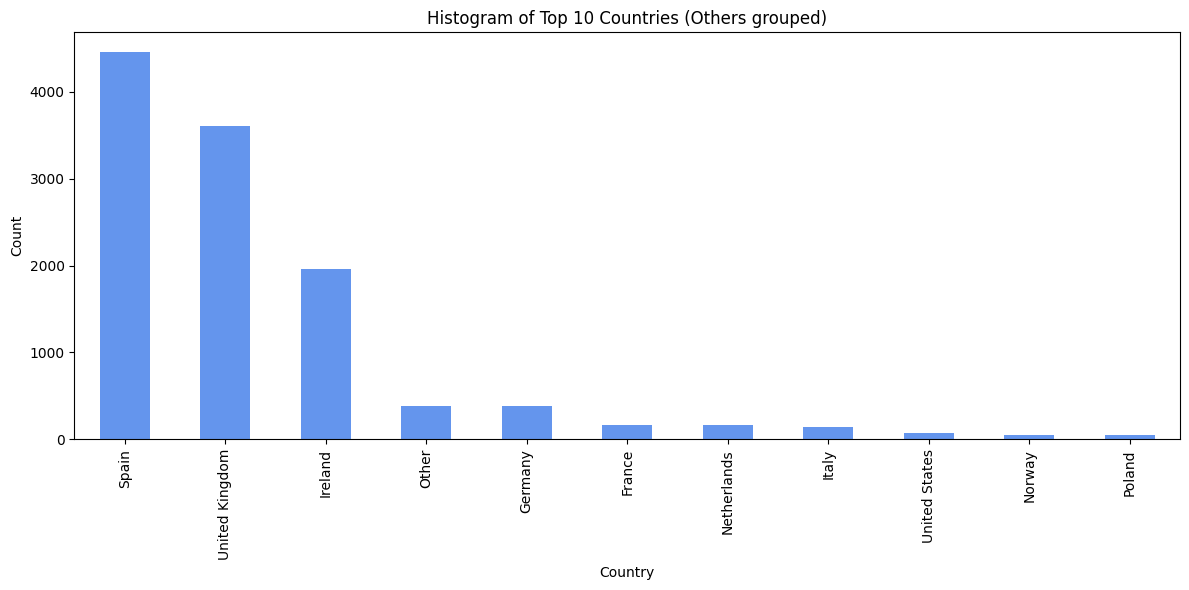

In [13]:
top_countries = df_users['country'].value_counts().nlargest(10).index
country_grouped = df_users['country'].where(df_users['country'].isin(top_countries), 'Other')

country_grouped.value_counts().plot(kind='bar', figsize=(12, 6), color='cornflowerblue')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Histogram of Top 10 Countries (Others grouped)')
plt.tight_layout()
plt.show()

Podemos observar que es curioso ver que en el dataset de todos los eventos el páis más repetido es Reino Unido, sin embargo cuando agrupamos por usuarios, vemos que el mayor número de visitantes son españoles, esto nos hace pensar que la media de eventos será mayor en usuarios de Reino Unido que de España, comprobémoslo.

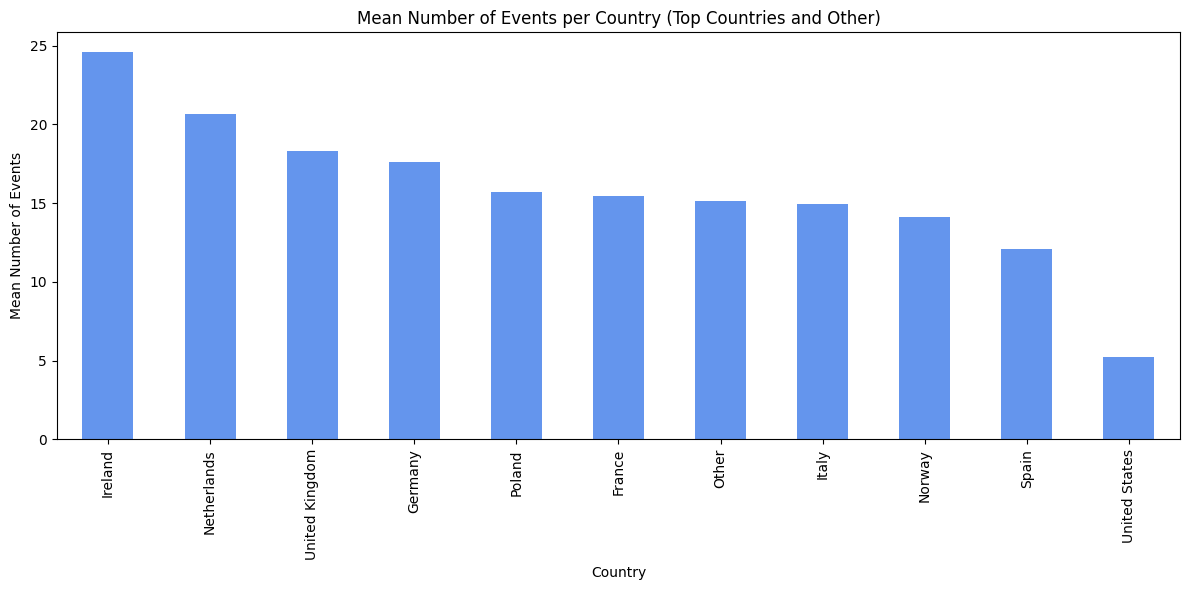

In [14]:
mean_events_by_group = df_users.groupby(country_grouped)['num_events'].mean().sort_values(ascending=False)

mean_events_by_group.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')
plt.xlabel('Country')
plt.ylabel('Mean Number of Events')
plt.title('Mean Number of Events per Country (Top Countries and Other)')
plt.tight_layout()
plt.show()

Tal y como se podía intuir, España tiene una de las medias mas bajas de eventos por usuario a pesar de representar la mayoría de los usuarios de la página.

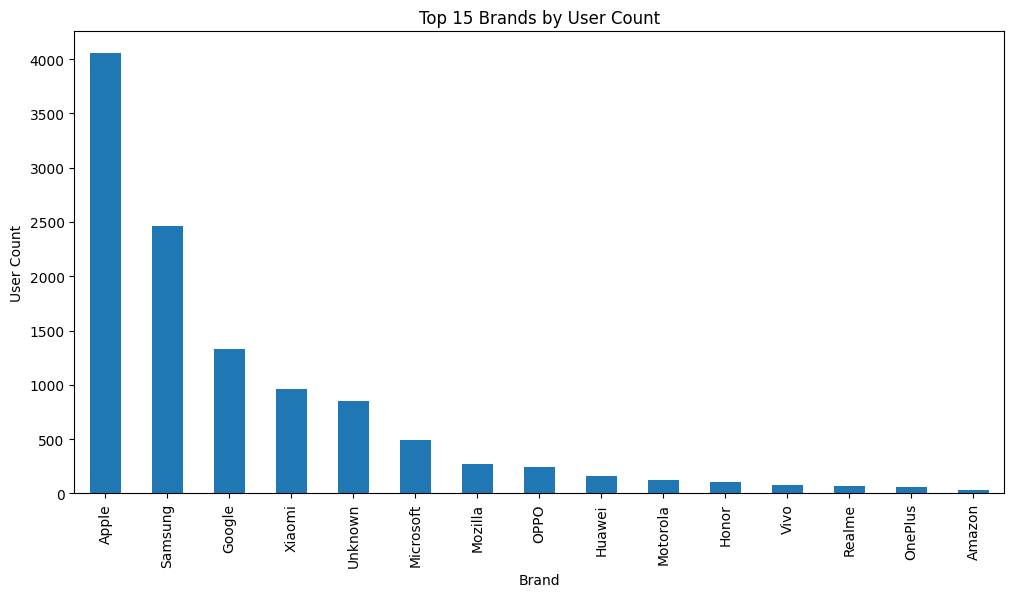

In [15]:
top_15_brands = df_users['brand'].value_counts().nlargest(15)
top_15_brands.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Brand')
plt.ylabel('User Count')
plt.title('Top 15 Brands by User Count')
plt.show()

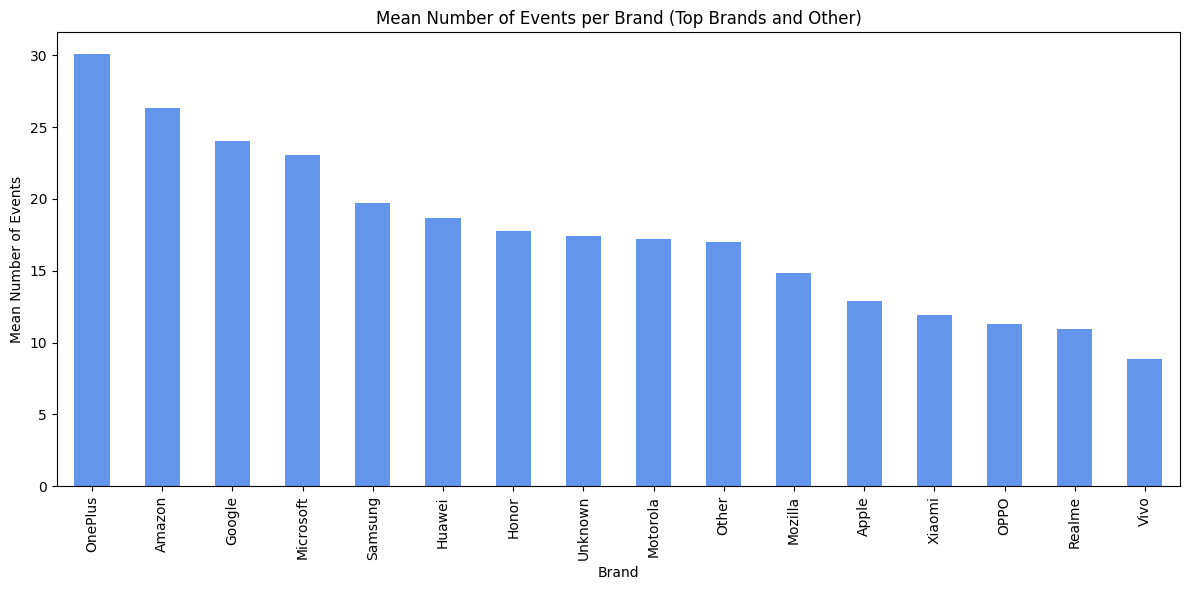

In [16]:
top_brands = df_users['brand'].value_counts().nlargest(15).index
brand_grouped = df_users['brand'].where(df_users['brand'].isin(top_brands), 'Other')

mean_events_by_brand = df_users.groupby(brand_grouped)['num_events'].mean().sort_values(ascending=False)

mean_events_by_brand.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')
plt.xlabel('Brand')
plt.ylabel('Mean Number of Events')
plt.title('Mean Number of Events per Brand (Top Brands and Other)')
plt.tight_layout()
plt.show()

En estas dos gráficas vemos los mismos estudios, pero esta vez según las marcas de dispositivo, y vemos que ocurre algo muy similar on Apple a lo ocurrido con España: representan la mayoría de los usuarios, pero tienen una media de eventos más baja. 

In [ ]:
df_users_purchase = df_users[df_users['purchase'] == 1]

mean_time_by_country_days = (
    df_users_purchase.groupby('country')['time_difference(seconds)']
    .mean()
    .div(86400) 
    .sort_values(ascending=False)
)

print(mean_time_by_country_days)

country
Netherlands       36.231505
Spain             24.313380
Ireland           12.062188
Germany            7.601256
United Kingdom     7.597222
France             3.862831
Austria            1.862085
Lithuania          0.997380
Sweden             0.086553
Belgium            0.035149
Slovakia           0.014756
Italy              0.014322
Czechia            0.008627
Name: time_difference(seconds), dtype: float64


FIltramos solo a los usuarios que han heho compras, y observamos la diferencia de tiempo entre su primera conexión y la compra. Destaca que España, dobla a Irlanda  y triplica a los usuarios de Reino Unido.

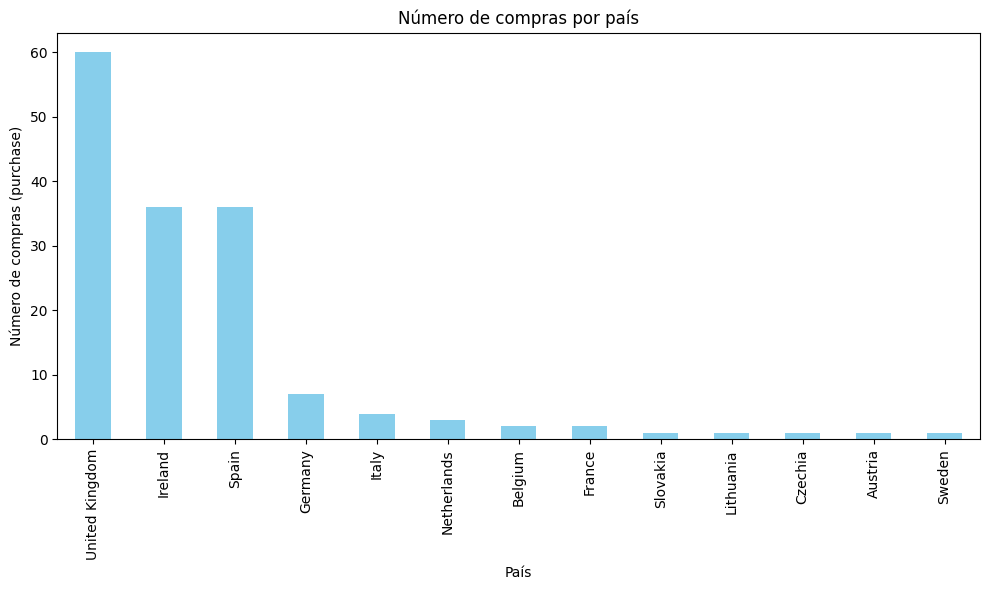

In [18]:
df_users_purchase['country'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('País')
plt.ylabel('Número de compras (purchase)')
plt.title('Número de compras por país')
plt.tight_layout()
plt.show()

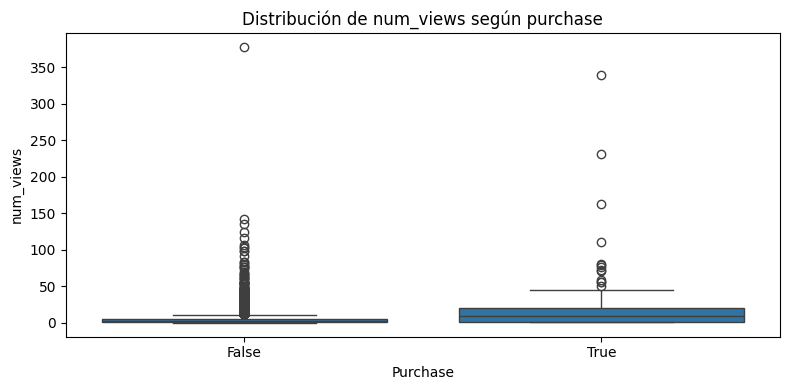

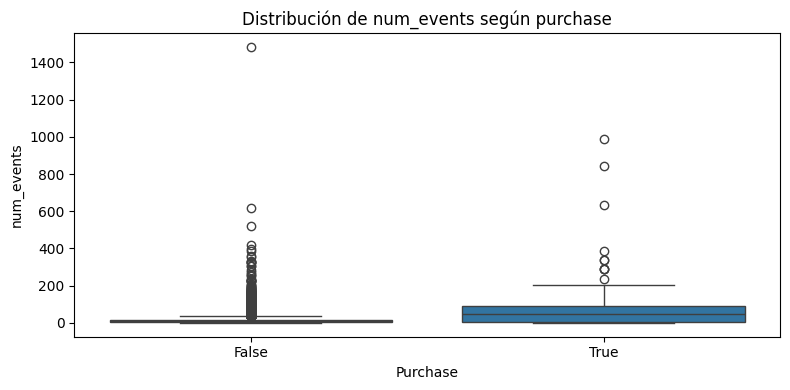

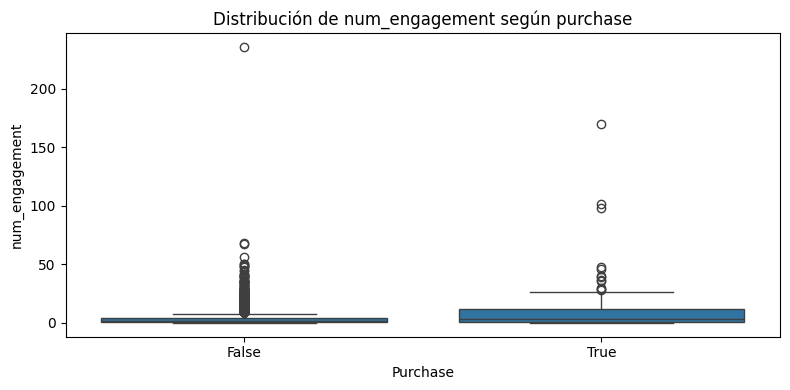

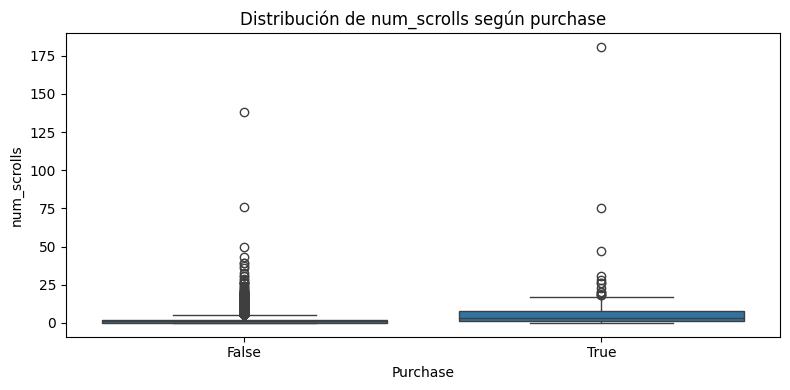

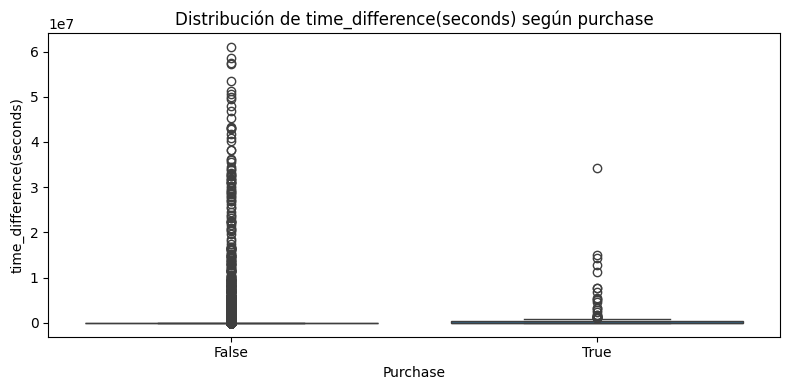

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

num_vars = ['num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']

for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='purchase', y=var, data=df_users)
    plt.title(f'Distribución de {var} según purchase')
    plt.xlabel('Purchase')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()

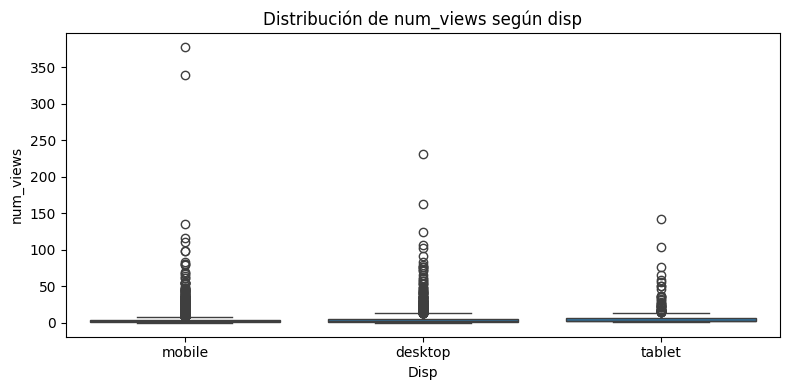

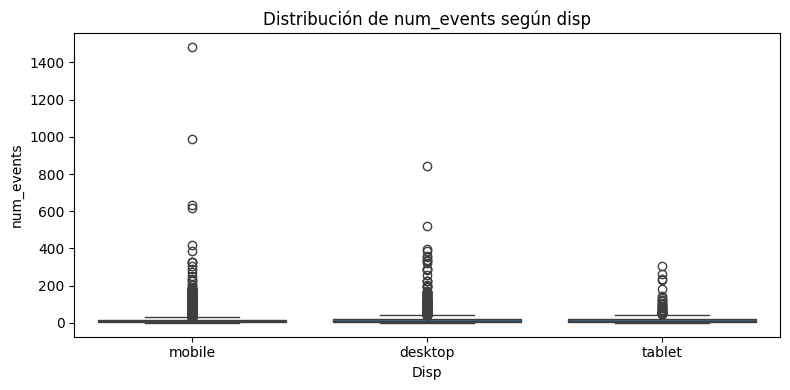

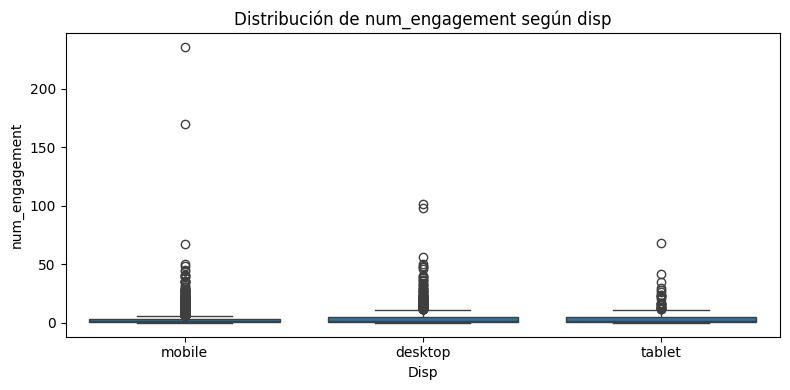

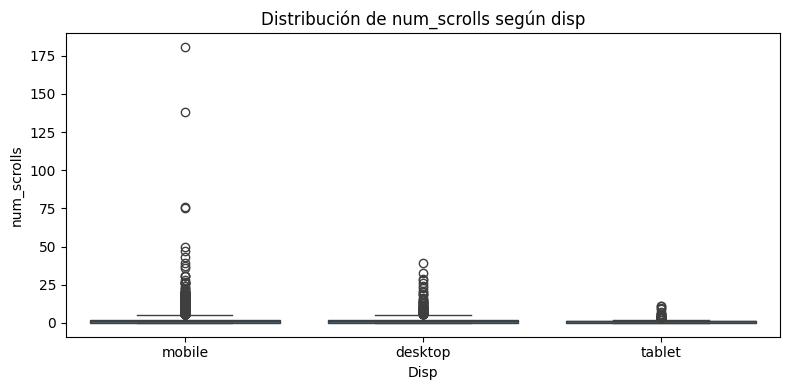

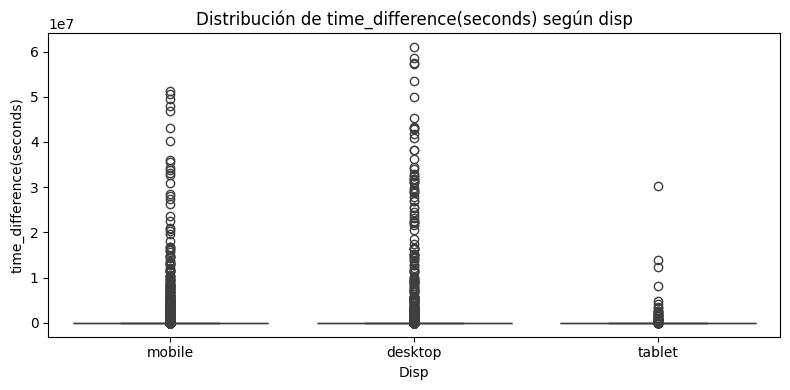

In [20]:
import seaborn as sns

import matplotlib.pyplot as plt

num_vars = ['num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']

for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='disp', y=var, data=df_users)
    plt.title(f'Distribución de {var} según disp')
    plt.xlabel('Disp')
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()

Después de ver estas gráficas sobre las distribuciones, apliquemos a nuestro dataset procesado la función para procesar eventos de compra del módulo process_purchase.

In [23]:
df_purchase = process_purchase_events(df_processed)

df_purchase

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_purchase.py:63: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,user_pseudo_id,event_name,hotelName,valor,room_name,room_code,room_occupancy,check_in,check_out,event_date,time_difference,TotalNights,DaysToCheckIn
22077,151982344.1732715181,purchase,Apartments Las Gaviotas,787.069934,Standard Apartment Plus,aptstdplus,2-0-0,2024-11-30,2024-12-07,2024-12-01,3 days 19:53:23.417000,7,-1
276029,1631356880.1721985482,purchase,Apartamentos LIVVO Las Gaviotas,1044.262295,Apartamento Superior,aptsup,2-0-0,2025-03-16,2025-03-25,2024-12-02,129 days 00:09:07.451000,9,104
154689,533248603.1733139931,purchase,Apartments Las Gaviotas,999.175040,Superior Apartment,aptsup,2-2-0,2025-02-12,2025-02-19,2024-12-02,0 days 01:12:17.665000,7,72
200057,1076425916.1732130798,purchase,Apartments Las Gaviotas,909.613961,Superior Apartment,aptsup,2-0-0,2025-03-16,2025-03-23,2024-12-02,11 days 18:14:33.829000,7,104
300518,547625027.1732887558,purchase,Hotel LIVVO Lumm,104.664199,Doble Estándar,dbl,1-0-0,2024-12-09,2024-12-10,2024-12-02,3 days 01:16:28.729000,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249011,100102787.1737560920,purchase,Apartments Las Gaviotas,1264.713568,Superior Apartment,aptsup,2-0-0,2025-06-06,2025-06-16,2025-02-07,15 days 22:44:05.516000,10,119
17134,694310412.1738969083,purchase,Apartments Las Gaviotas,486.898406,Superior Apartment,aptsup,2-0-0,2025-04-10,2025-04-14,2025-02-08,0 days 00:59:36.282000,4,61
173186,1782557784.1739031007,purchase,Apartments Las Gaviotas,746.999473,Standard Apartment Plus,aptstdplus,2-0-0,2026-01-01,2026-01-07,2025-02-08,0 days 00:18:26.992000,6,327
81880,1327684706.1738863756,purchase,Apartments Las Gaviotas,124.943779,Standard Apartment Plus,aptstdplus,2-2-0,2025-03-01,2025-03-02,2025-02-09,3 days 01:55:18.404000,1,20


In [24]:
hotel_name_mapping = {
    'Apartments Las Gaviotas': 'LIVVO Las Gaviotas',
    'Apartamentos LIVVO Las Gaviotas': 'LIVVO Las Gaviotas',
    'Apartments LIVVO  Las Gaviotas': 'LIVVO Las Gaviotas'
}

# Aplicar el mapeo
df_purchase['hotelName'] = df_purchase['hotelName'].replace(hotel_name_mapping)

C:\Users\reyme\AppData\Local\Temp\ipykernel_36104\1456791591.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




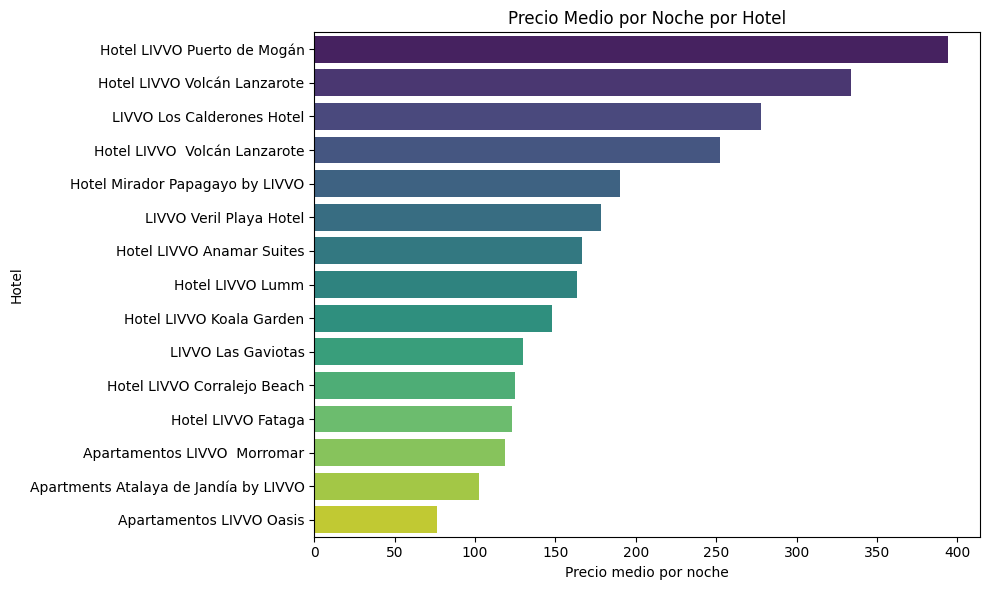

In [25]:
df_purchase['price_per_night'] = df_purchase['valor'] / df_purchase['TotalNights']

mean_price_per_hotel = (
    df_purchase.groupby('hotelName')['price_per_night']
    .mean()
    .reset_index()
    .sort_values(by='price_per_night', ascending=False)
)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_price_per_hotel, x='price_per_night', y='hotelName', palette='viridis')
plt.title('Precio Medio por Noche por Hotel')
plt.xlabel('Precio medio por noche')
plt.ylabel('Hotel')
plt.tight_layout()
plt.show()

Vemos la media de precio por noche según los hoteles registrados en las compras de la base de datos

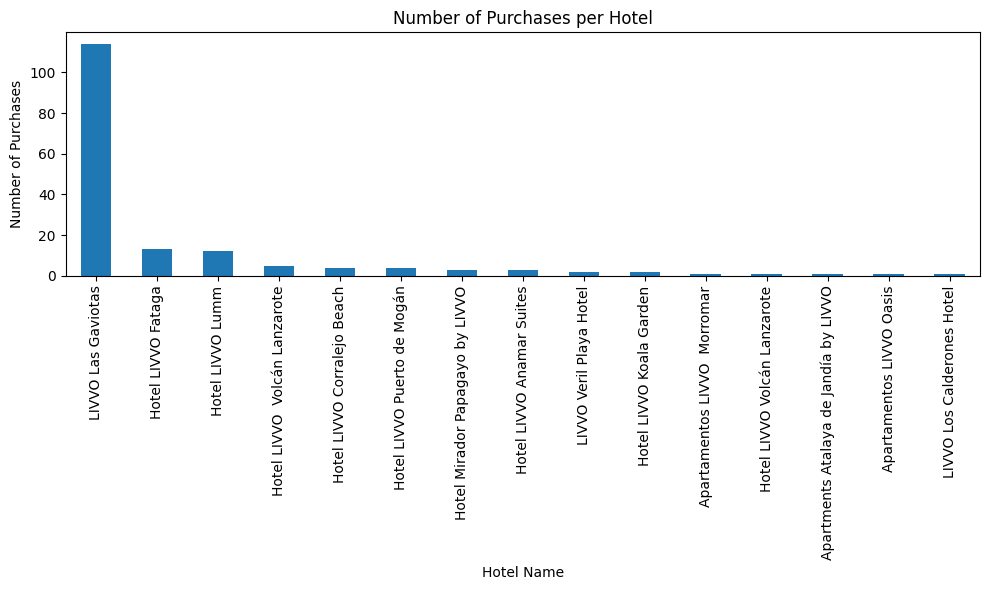

In [26]:
df_purchase['hotelName'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Hotel Name')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases per Hotel')
plt.tight_layout()
plt.show()

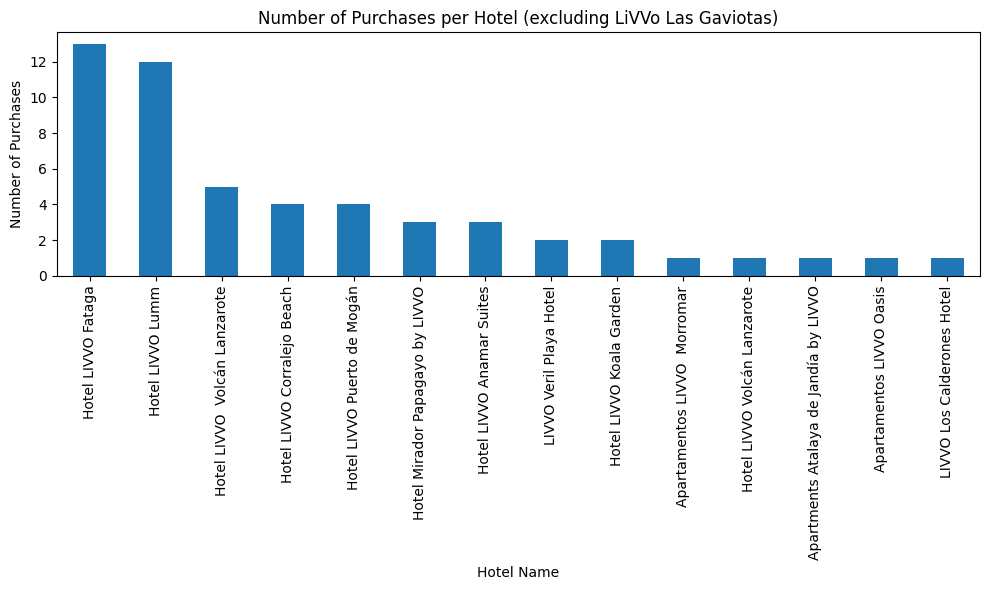

In [27]:
df_filtrado = df_purchase[df_purchase['hotelName'] != "LIVVO Las Gaviotas"]

df_filtrado['hotelName'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Hotel Name')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases per Hotel (excluding LiVVo Las Gaviotas)')
plt.tight_layout()
plt.show()

Ahora, vamos a ver gráficas donde se está estudiando la estacionalidad de 3 eventos: compra, añadir al carrito y no disponibilidad. Para cada eventos hay dos gráficas, una que la muestra por meses y otra por días. Para hacerlo, se aplicarán las funciones definidas en los módulos de cada evento, para generar las tablas correspondientes.

C:\Users\reyme\AppData\Local\Temp\ipykernel_36104\1381961957.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




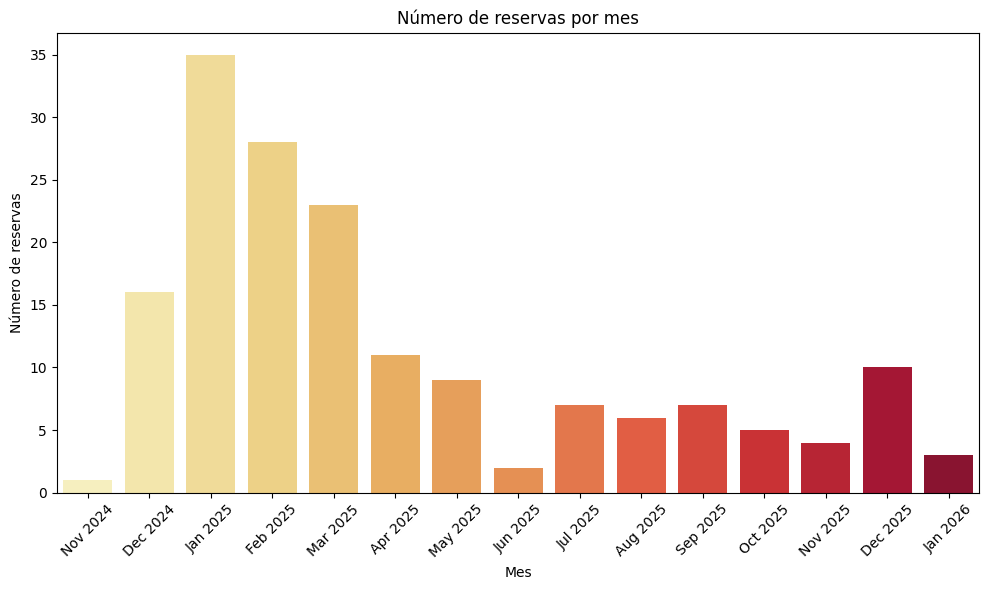

In [ ]:
df_purchase['check_in'] = pd.to_datetime(df_purchase['check_in'])
df_purchase['mes'] = df_purchase['check_in'].dt.to_period('M').dt.to_timestamp()

df_reservas_mes = df_purchase.groupby('mes').size().reset_index(name='num_reservas')

plt.figure(figsize=(10, 6))
sns.barplot(x=df_reservas_mes['mes'].dt.strftime('%b %Y'), y=df_reservas_mes['num_reservas'], palette='YlOrRd')
plt.xticks(rotation=45)
plt.xlabel('Mes')
plt.ylabel('Número de reservas')
plt.title('Número de reservas por mes')
plt.tight_layout()
plt.show()

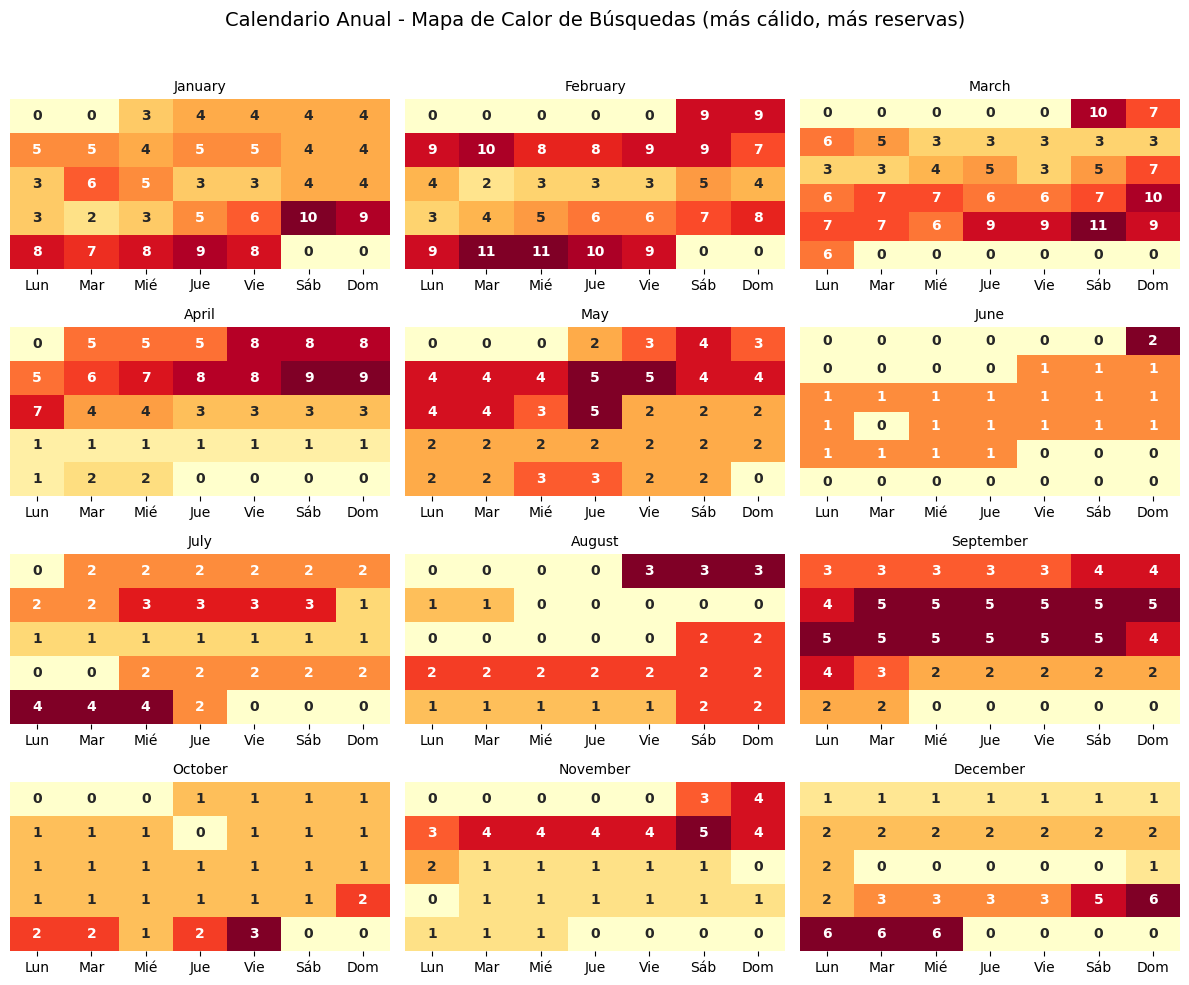

In [29]:
df_purchase['check_in'] = pd.to_datetime(df_purchase['check_in'])
df_purchase['check_out'] = pd.to_datetime(df_purchase['check_out'])

# Generar una estructura para contar cuántas veces se ha reservado cada día
reserved_count = {}

# Contamos las reservas
for checkin, checkout in zip(df_purchase['check_in'], df_purchase['check_out']):
    for single_date in pd.date_range(checkin, checkout, freq='D'):
        date_str = single_date.strftime('%Y-%m-%d')
        if date_str in reserved_count:
            reserved_count[date_str] += 1
        else:
            reserved_count[date_str] = 1

# 📅 Generar los 12 meses del año
year = 2025
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))

# Crear la paleta de colores
cmap = sns.color_palette("YlOrRd", as_cmap=True)  # Paleta de colores cálidos (amarillo-rojo)

for month in range(1, 13):
    ax = axes[(month - 1) // 3, (month - 1) % 3]
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

    # Generar calendario del mes
    cal = calendar.Calendar(firstweekday=0)
    month_days = cal.monthdayscalendar(year, month)

    # Crear una matriz para contar las reservas por día
    heatmap_data = [[0] * 7 for _ in range(len(month_days))]  # Inicializamos la matriz con ceros

    for week_idx, week in enumerate(month_days):
        for day_idx, day in enumerate(week):
            if day == 0:
                continue  # Días fuera del mes
            date_str = f"{year}-{month:02d}-{day:02d}"
            if date_str in reserved_count:
                heatmap_data[week_idx][day_idx] = reserved_count[date_str]

    # Dibujar el mapa de calor
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax, 
                xticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'], 
                yticklabels=[], annot_kws={"size": 10, "weight": 'bold'})
    
    # Ajustes finales del mes
    ax.set_title(calendar.month_name[month], fontsize=10)
    ax.set_yticks([])

plt.suptitle(f'Calendario Anual - Mapa de Calor de Búsquedas (más cálido, más reservas)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [31]:
from files.process_na import process_no_availability_events

df_event_na = process_no_availability_events(df_processed)

df_event_na

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_na.py:48: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,user_pseudo_id,hotelName,checkinDate,checkoutDate,room1_occupancy,event_date,time_difference,TotalNights,DaysToCheckIn
22751,1637459794.1733016091,Apartments Las Gaviotas,2024-12-01,2024-12-02,2-0-0,2024-12-01,0 days 00:00:08.477000,1,0
292875,1854593609.1732813265,Apartments Las Gaviotas,2025-11-17,2025-11-24,2-0-0,2024-12-01,2 days 15:36:48.526000,7,351
102782,1854593609.1732813265,Apartments Las Gaviotas,2026-01-05,2026-01-12,2-0-0,2024-12-01,2 days 15:37:55.817000,7,400
310865,112948208.1733042509,Apartments Las Gaviotas,2024-12-21,2024-12-28,2-0-0,2024-12-01,0 days 00:01:12.986000,7,20
28555,305318990.1730626037,Apartments Las Gaviotas,2024-12-23,2025-01-03,2-0-0,2024-12-01,27 days 23:24:33.964000,11,22
...,...,...,...,...,...,...,...,...,...
78056,1062176343.1739136739,Apartments Las Gaviotas,2025-02-19,2025-02-24,3-1-0,2025-02-09,0 days 00:01:46.425000,5,10
54078,1960968986.1739141114,Apartments Las Gaviotas,2025-03-06,2025-03-09,3-0-0,2025-02-09,0 days 00:00:45.489000,3,25
39102,1960968986.1739141114,Apartments Las Gaviotas,2025-03-06,2025-03-09,3-0-0,2025-02-09,0 days 00:03:25.119000,3,25
205018,1103365091.1739141849,Apartments Las Gaviotas,2025-02-22,2025-02-28,1-0-0,2025-02-09,0 days 00:00:14.754000,6,13


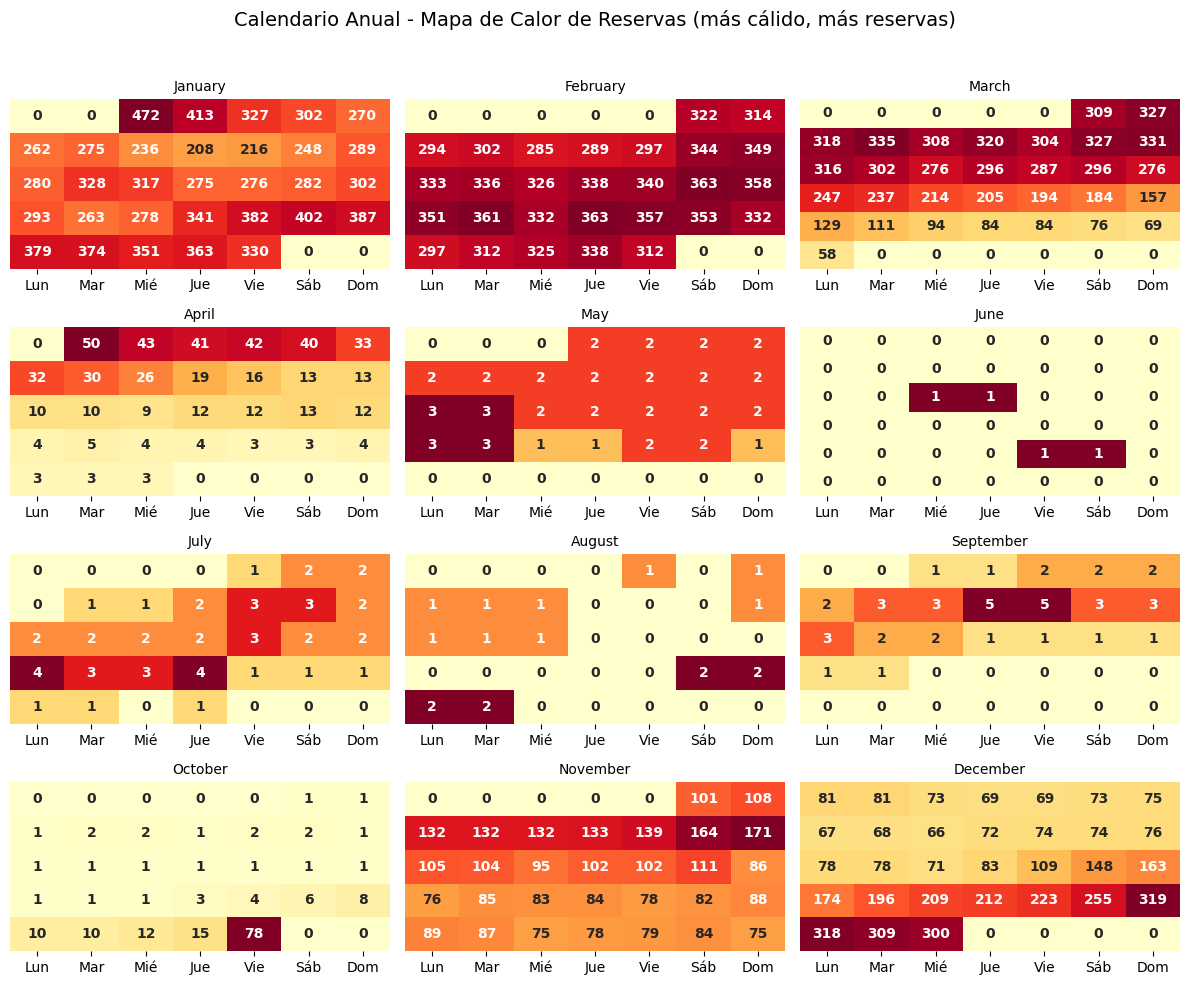

In [32]:
df_event_na['checkinDate'] = pd.to_datetime(df_event_na['checkinDate'])
df_event_na['checkoutDate'] = pd.to_datetime(df_event_na['checkoutDate'])
df_event_na['event_date'] = pd.to_datetime(df_event_na['event_date'])

# Generar una estructura para contar cuántas veces se ha reservado cada día
reserved_count = {}

# Contamos las reservas
for checkin, checkout, event_date in zip(df_event_na['checkinDate'], df_event_na['checkoutDate'], df_event_na['event_date']):
    for single_date in pd.date_range(checkin, checkout, freq='D'):
        # Si checkinDate es igual a event_date, no lo contamos
        if single_date == event_date:
            continue
        
        date_str = single_date.strftime('%Y-%m-%d')
        if date_str in reserved_count:
            reserved_count[date_str] += 1
        else:
            reserved_count[date_str] = 1

# 📅 Generar los 12 meses del año
year = 2025
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))

# Crear la paleta de colores
cmap = sns.color_palette("YlOrRd", as_cmap=True)  # Paleta de colores cálidos (amarillo-rojo)

for month in range(1, 13):
    ax = axes[(month - 1) // 3, (month - 1) % 3]
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

    # Generar calendario del mes
    cal = calendar.Calendar(firstweekday=0)
    month_days = cal.monthdayscalendar(year, month)

    # Crear una matriz para contar las reservas por día
    heatmap_data = [[0] * 7 for _ in range(len(month_days))]  # Inicializamos la matriz con ceros

    for week_idx, week in enumerate(month_days):
        for day_idx, day in enumerate(week):
            if day == 0:
                continue  # Días fuera del mes
            date_str = f"{year}-{month:02d}-{day:02d}"
            if date_str in reserved_count:
                heatmap_data[week_idx][day_idx] = reserved_count[date_str]

    # Dibujar el mapa de calor
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax, 
                xticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'], 
                yticklabels=[], annot_kws={"size": 10, "weight": 'bold'})
    
    # Ajustes finales del mes
    ax.set_title(calendar.month_name[month], fontsize=10)
    ax.set_yticks([])

# Ajustar el diseño del gráfico
plt.suptitle(f'Calendario Anual - Mapa de Calor de Reservas (más cálido, más reservas)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\reyme\AppData\Local\Temp\ipykernel_36104\730083963.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




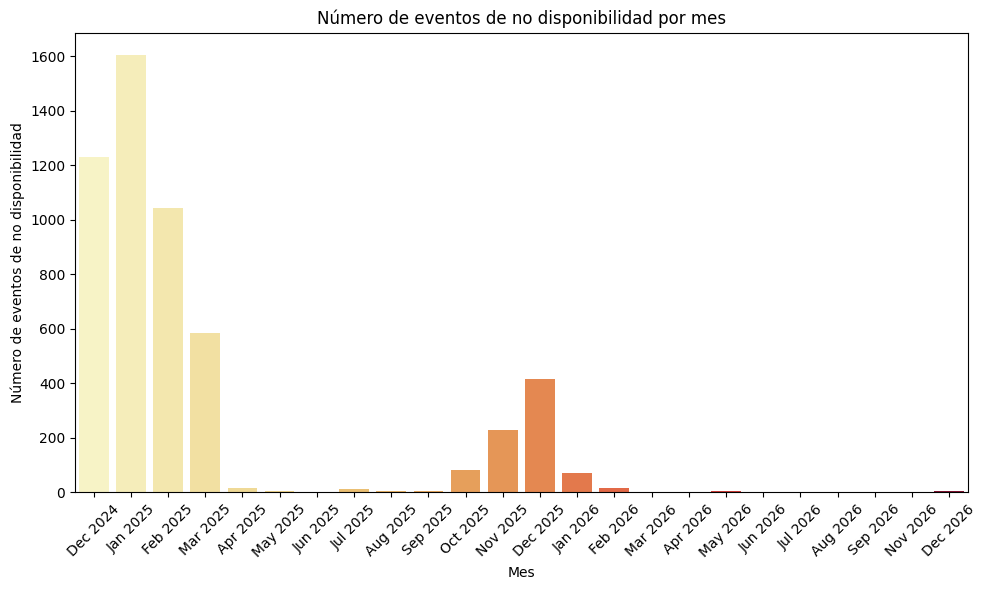

In [33]:
# Asegurar tipo datetime
df_event_na['checkinDate'] = pd.to_datetime(df_event_na['checkinDate'])

# Crear una columna 'mes' en formato datetime
df_event_na['mes'] = df_event_na['checkinDate'].dt.to_period('M').dt.to_timestamp()

# Contar reservas por mes
df_reservas_mes = df_event_na.groupby('mes').size().reset_index(name='num_reservas')

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=df_reservas_mes['mes'].dt.strftime('%b %Y'), y=df_reservas_mes['num_reservas'], palette='YlOrRd')
plt.xticks(rotation=45)
plt.xlabel('Mes')
plt.ylabel('Número de eventos de no disponibilidad')
plt.title('Número de eventos de no disponibilidad por mes')
plt.tight_layout()
plt.show()

In [35]:
data_add = df_processed[df_processed['event_name'] == 'add_to_cart']


In [37]:
df_add = process_add_to_cart_events(data_add)

df_add

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_add.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_add.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\process_add.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,user_pseudo_id,event_name,hotelName,room_name,room_code,room_occupancy,check_in,check_out,event_date,time_difference,TotalNights,DaysToCheckIn
256200,1930757006.1733045935,add_to_cart,Apartments Las Gaviotas,Superior Apartment,aptsup,1-1-0,2025-02-14,2025-02-21,2024-12-01,0 days 00:01:10.151000,7,75
195619,1467250310.1733045268,add_to_cart,Apartments Las Gaviotas,Double Apartment,aptdoble,2-0-0,2025-01-23,2025-01-26,2024-12-01,0 days 00:15:50.472000,3,53
83743,1467250310.1733045268,add_to_cart,Apartments Las Gaviotas,Double Apartment,aptdoble,3-0-0,2025-01-23,2025-01-26,2024-12-01,0 days 00:23:00.957000,3,53
231970,1709362228.1732817811,add_to_cart,Apartments Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-10-08,2025-10-22,2024-12-01,2 days 16:22:10.043000,14,311
180242,1576563685.1724937259,add_to_cart,Apartments Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2025-03-14,2025-03-18,2024-12-01,93 days 21:36:06.507000,4,103
...,...,...,...,...,...,...,...,...,...,...,...,...
244403,1281051844.1739121667,add_to_cart,Apartments Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2025-09-25,2025-10-02,2025-02-09,0 days 00:06:44.471000,7,228
48405,1327684706.1738863756,add_to_cart,Apartments Las Gaviotas,Standard Apartment Plus,aptstdplus,2-2-0,2025-03-01,2025-03-02,2025-02-09,3 days 01:50:08.899000,1,20
80472,1249386008.1739131611,add_to_cart,Apartments Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-10-09,2025-10-22,2025-02-09,0 days 00:01:03.444000,13,242
83658,64252549.1739132259,add_to_cart,Apartamentos LIVVO Las Gaviotas,Apartamento Doble (2 Dormitorios),aptdoble,2-2-0,2025-08-02,2025-08-09,2025-02-09,0 days 00:02:29.962000,7,174


In [38]:
df_add.info()

<class 'pandas.core.frame.DataFrame'>
Index: 799 entries, 256200 to 185223
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   user_pseudo_id   799 non-null    object         
 1   event_name       799 non-null    object         
 2   hotelName        799 non-null    object         
 3   room_name        799 non-null    object         
 4   room_code        799 non-null    object         
 5   room_occupancy   799 non-null    object         
 6   check_in         799 non-null    datetime64[ns] 
 7   check_out        799 non-null    datetime64[ns] 
 8   event_date       799 non-null    datetime64[ns] 
 9   time_difference  799 non-null    timedelta64[ns]
 10  TotalNights      799 non-null    int64          
 11  DaysToCheckIn    799 non-null    int64          
dtypes: datetime64[ns](3), int64(2), object(6), timedelta64[ns](1)
memory usage: 81.1+ KB


In [39]:
df_add['hotelName'] = df_add['hotelName'].replace(hotel_name_mapping)

In [40]:
df_add

,user_pseudo_id,event_name,hotelName,room_name,room_code,room_occupancy,check_in,check_out,event_date,time_difference,TotalNights,DaysToCheckIn
256200,1930757006.1733045935,add_to_cart,LIVVO Las Gaviotas,Superior Apartment,aptsup,1-1-0,2025-02-14,2025-02-21,2024-12-01,0 days 00:01:10.151000,7,75
195619,1467250310.1733045268,add_to_cart,LIVVO Las Gaviotas,Double Apartment,aptdoble,2-0-0,2025-01-23,2025-01-26,2024-12-01,0 days 00:15:50.472000,3,53
83743,1467250310.1733045268,add_to_cart,LIVVO Las Gaviotas,Double Apartment,aptdoble,3-0-0,2025-01-23,2025-01-26,2024-12-01,0 days 00:23:00.957000,3,53
231970,1709362228.1732817811,add_to_cart,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-10-08,2025-10-22,2024-12-01,2 days 16:22:10.043000,14,311
180242,1576563685.1724937259,add_to_cart,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2025-03-14,2025-03-18,2024-12-01,93 days 21:36:06.507000,4,103
...,...,...,...,...,...,...,...,...,...,...,...,...
244403,1281051844.1739121667,add_to_cart,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2025-09-25,2025-10-02,2025-02-09,0 days 00:06:44.471000,7,228
48405,1327684706.1738863756,add_to_cart,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-2-0,2025-03-01,2025-03-02,2025-02-09,3 days 01:50:08.899000,1,20
80472,1249386008.1739131611,add_to_cart,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-10-09,2025-10-22,2025-02-09,0 days 00:01:03.444000,13,242
83658,64252549.1739132259,add_to_cart,LIVVO Las Gaviotas,Apartamento Doble (2 Dormitorios),aptdoble,2-2-0,2025-08-02,2025-08-09,2025-02-09,0 days 00:02:29.962000,7,174


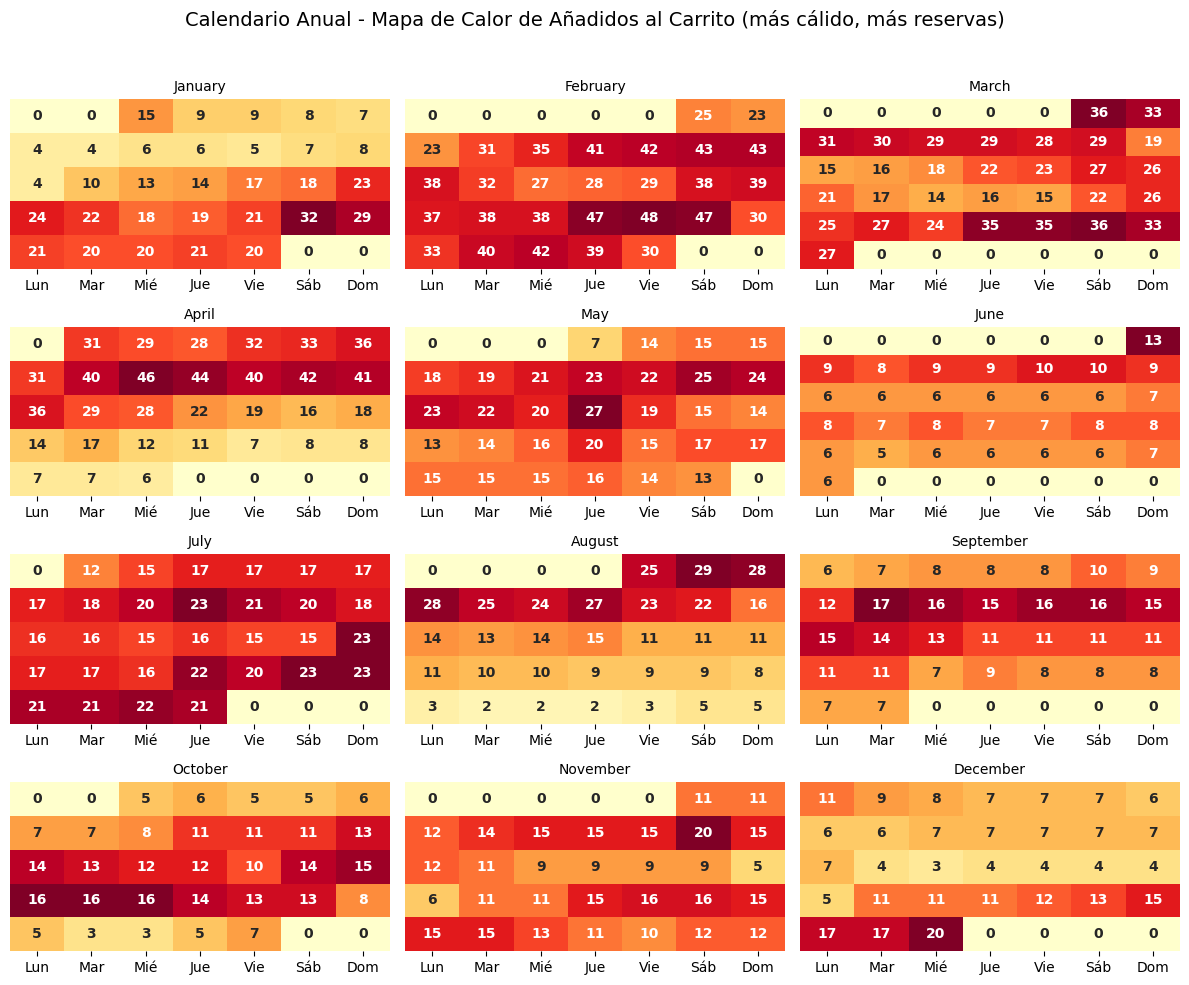

In [41]:
df_add['check_in'] = pd.to_datetime(df_add['check_in'])
df_add['check_out'] = pd.to_datetime(df_add['check_out'])
df_add['event_date'] = pd.to_datetime(df_add['event_date'])

# Generar una estructura para contar cuántas veces se ha reservado cada día
reserved_count = {}

# Contamos las reservas
for checkin, checkout, event_date in zip(df_add['check_in'], df_add['check_out'], df_add['event_date']):
    for single_date in pd.date_range(checkin, checkout, freq='D'):
        # Si check_in es igual a event_date, no lo contamos
        if single_date == event_date:
            continue
        
        date_str = single_date.strftime('%Y-%m-%d')
        if date_str in reserved_count:
            reserved_count[date_str] += 1
        else:
            reserved_count[date_str] = 1

# 📅 Generar los 12 meses del año
year = 2025
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))

# Crear la paleta de colores
cmap = sns.color_palette("YlOrRd", as_cmap=True)  # Paleta de colores cálidos (amarillo-rojo)

for month in range(1, 13):
    ax = axes[(month - 1) // 3, (month - 1) % 3]
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

    # Generar calendario del mes
    cal = calendar.Calendar(firstweekday=0)
    month_days = cal.monthdayscalendar(year, month)

    # Crear una matriz para contar las reservas por día
    heatmap_data = [[0] * 7 for _ in range(len(month_days))]  # Inicializamos la matriz con ceros

    for week_idx, week in enumerate(month_days):
        for day_idx, day in enumerate(week):
            if day == 0:
                continue  # Días fuera del mes
            date_str = f"{year}-{month:02d}-{day:02d}"
            if date_str in reserved_count:
                heatmap_data[week_idx][day_idx] = reserved_count[date_str]

    # Dibujar el mapa de calor
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax, 
                xticklabels=['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'], 
                yticklabels=[], annot_kws={"size": 10, "weight": 'bold'})
    
    # Ajustes finales del mes
    ax.set_title(calendar.month_name[month], fontsize=10)
    ax.set_yticks([])

# Ajustar el diseño del gráfico
plt.suptitle(f'Calendario Anual - Mapa de Calor de Añadidos al Carrito (más cálido, más reservas)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

C:\Users\reyme\AppData\Local\Temp\ipykernel_36104\2034651587.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




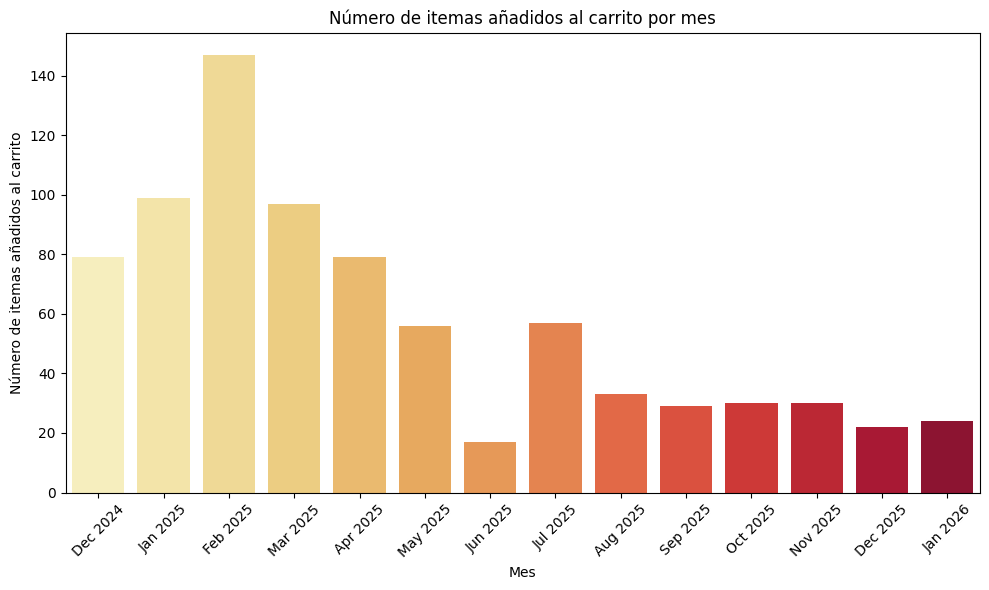

In [42]:
# Asegurar tipo datetime
df_add['check_in'] = pd.to_datetime(df_add['check_in'])

# Crear una columna 'mes' en formato datetime
df_add['mes'] = df_add['check_in'].dt.to_period('M').dt.to_timestamp()

# Contar reservas por mes
df_reservas_mes = df_add.groupby('mes').size().reset_index(name='num_reservas')

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=df_reservas_mes['mes'].dt.strftime('%b %Y'), y=df_reservas_mes['num_reservas'], palette='YlOrRd')
plt.xticks(rotation=45)
plt.xlabel('Mes')
plt.ylabel('Número de itemas añadidos al carrito')
plt.title('Número de itemas añadidos al carrito por mes')
plt.tight_layout()
plt.show()

# Modelado del comportamiento del consumidor y búsqueda de patrones


Para realizar el modelado del consumidor, no nos valen las tablas que ya tenemos, puesto que sería muy poco eficiente realizar el modelado con todos esas variables. Elegiremos variables que consideremos importantes y crearemos una base de datos para empezar con el modelado y la búsqueda de patrones.

In [43]:
df_users.head()

,user_pseudo_id,city,country,disp,brand,purchase,no_availability,refund,add_to_cart,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date
0,1000075147.1736646133,Puerto del Carmen,Spain,mobile,Unknown,False,True,False,False,8.0,38.0,2.0,4.0,19665.369,2025-01-12,2025-01-12
1,1000409496.1736677314,Limerick,Ireland,desktop,Google,False,True,False,False,20.0,96.0,11.0,13.0,48682.067,2025-01-12,2025-01-13
2,1000410660.1734943681,Madrid,Spain,mobile,Xiaomi,False,True,False,False,5.0,18.0,3.0,2.0,72.748,2024-12-23,2024-12-23
3,1000560983.1733155660,Mallow,Ireland,desktop,Apple,False,False,False,False,1.0,2.0,1.0,0.0,0.000,2024-12-02,2024-12-02
4,1000661678.1734282826,Dagenham,United Kingdom,mobile,Apple,False,False,False,False,1.0,5.0,2.0,0.0,9.020,2024-12-15,2024-12-15


In [44]:
df_model = df_users.copy()
df_model['conversion'] = df_model[['purchase', 'add_to_cart']].any(axis=1).astype(int)

In [45]:
df_model = df_model.drop(columns=['purchase', 'add_to_cart', 'city'])
df_model

,user_pseudo_id,country,disp,brand,no_availability,refund,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date,conversion
0,1000075147.1736646133,Spain,mobile,Unknown,True,False,8.0,38.0,2.0,4.0,19665.369,2025-01-12,2025-01-12,0
1,1000409496.1736677314,Ireland,desktop,Google,True,False,20.0,96.0,11.0,13.0,48682.067,2025-01-12,2025-01-13,0
2,1000410660.1734943681,Spain,mobile,Xiaomi,True,False,5.0,18.0,3.0,2.0,72.748,2024-12-23,2024-12-23,0
3,1000560983.1733155660,Ireland,desktop,Apple,False,False,1.0,2.0,1.0,0.0,0.000,2024-12-02,2024-12-02,0
4,1000661678.1734282826,United Kingdom,mobile,Apple,False,False,1.0,5.0,2.0,0.0,9.020,2024-12-15,2024-12-15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11471,998917149.1735450876,Ireland,mobile,Samsung,True,False,7.0,26.0,2.0,4.0,221.310,2024-12-29,2024-12-29,0
11472,999288322.1737141434,Belgium,desktop,Microsoft,True,False,8.0,33.0,4.0,2.0,0.000,2025-01-17,2025-01-17,0
11473,999607612.1737224674,Spain,mobile,Apple,False,False,3.0,9.0,1.0,1.0,181.257,2025-01-18,2025-01-18,0
11474,999655247.1732907158,United Kingdom,tablet,Amazon,False,False,5.0,19.0,1.0,2.0,226491.369,2024-12-02,2024-12-02,0


In [46]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11476 entries, 0 to 11475
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_pseudo_id            11476 non-null  object        
 1   country                   11476 non-null  object        
 2   disp                      11476 non-null  object        
 3   brand                     11476 non-null  object        
 4   no_availability           11476 non-null  bool          
 5   refund                    11476 non-null  bool          
 6   num_views                 11476 non-null  float64       
 7   num_events                11476 non-null  float64       
 8   num_engagement            11476 non-null  float64       
 9   num_scrolls               11476 non-null  float64       
 10  time_difference(seconds)  11476 non-null  float64       
 11  first_event_date          11476 non-null  datetime64[ns]
 12  last_event_date   

In [47]:
from scipy.stats import ttest_ind
import numpy as np

alpha = 0.01

num_vars = ['num_events', 'time_difference(seconds)', 'num_views', 'num_engagement', 'num_scrolls']

for var in num_vars:
    supera = df_model[df_model['conversion'] == 1][var]
    no_supera = df_model[df_model['conversion'] == 0][var]

    t_stat, p_val = ttest_ind(supera, no_supera)

    print(f"Variable: {var}, T-stat: {t_stat}, P-value: {p_val}")

    if p_val < alpha:
        print("Hay una diferencia significativa entre los grupos.\n")
    else:
        print("No hay diferencias significativas o la diferencia es trivial.\n")

Variable: num_events, T-stat: 39.70774602383867, P-value: 0.0
Hay una diferencia significativa entre los grupos.

Variable: time_difference(seconds), T-stat: 4.6319986920722, P-value: 3.6613459385528423e-06
Hay una diferencia significativa entre los grupos.

Variable: num_views, T-stat: 33.92735800169439, P-value: 1.5791236461435377e-240
Hay una diferencia significativa entre los grupos.

Variable: num_engagement, T-stat: 26.883468090855104, P-value: 1.9615741519378578e-154
Hay una diferencia significativa entre los grupos.

Variable: num_scrolls, T-stat: 33.454503789843066, P-value: 3.1608379861540657e-234
Hay una diferencia significativa entre los grupos.



In [48]:
X1 = df_model[[
    'country', 'disp', 'brand',
    'no_availability', 'refund',
    'num_views', 'num_events', 'num_engagement',
    'num_scrolls', 'time_difference(seconds)'
]]
y1 = df_model['conversion']

cat_features1 = ['country', 'disp', 'brand']
num_features1 = ['no_availability', 'refund', 'num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']

preprocessor1 = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features1),
    ('num', StandardScaler(), num_features1)
])

logreg_pipeline1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify=y1, test_size=0.2, random_state=42)

logreg_pipeline1.fit(X_train1, y_train1)

y_pred = logreg_pipeline1.predict(X_test1)
print("Logistic Regression Report:")
print(classification_report(y_test1, y_pred))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2171
           1       0.28      0.74      0.40       125

    accuracy                           0.88      2296
   macro avg       0.63      0.81      0.67      2296
weighted avg       0.94      0.88      0.90      2296



In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

cv_results = cross_validate(logreg_pipeline1, X1, y1, cv=cv, scoring=scoring)

print("\nCross-validation results (5 folds):")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean():.4f} ± {cv_results['test_' + metric].std():.4f}")


Cross-validation results (5 folds):
Accuracy: 0.8673 ± 0.0043
Precision: 0.2534 ± 0.0057
Recall: 0.7337 ± 0.0179
F1: 0.3767 ± 0.0067


In [50]:
ohe1 = logreg_pipeline1.named_steps['preprocessor'].named_transformers_['cat']
cat_columns1 = ohe1.get_feature_names_out(['country', 'disp', 'brand'])

num_columns = ['no_availability', 'refund', 'num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']
all_feature_names = np.concatenate([cat_columns1, num_columns])

coefs = logreg_pipeline1.named_steps['clf'].coef_[0]

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=abs, ascending=False)

coef_df.head(50)

,feature,coefficient
111,num_events,4.143741
22,country_Gibraltar,2.098014
4,country_Austria,1.845091
44,country_Norway,-1.802106
68,brand_Alcatel,1.742385
70,brand_Apple,1.682308
52,country_Slovakia,1.635252
36,country_Lithuania,1.539472
19,country_Finland,-1.512400
0,country_,1.376822


In [51]:
num_features = ['no_availability', 'refund', 'num_views', 'num_events',
                'num_engagement', 'num_scrolls', 'time_difference(seconds)']

X_num = df_users[num_features].copy().astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

vif_data = pd.DataFrame()
vif_data["feature"] = num_features
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                    feature        VIF
2                 num_views  21.431276
3                num_events  14.164725
4            num_engagement   7.208303
5               num_scrolls   3.874629
0           no_availability   1.143622
6  time_difference(seconds)   1.022906
1                    refund   1.003080


In [129]:
X2 = df_model[[
    'country', 'disp', 'brand',
    'no_availability', 'refund',
    'num_events', 'num_engagement',
    'num_scrolls', 'time_difference(seconds)'
]]
y2 = df_model['conversion']

cat_features2 = ['country', 'disp', 'brand']
num_features2 = ['no_availability', 'refund','num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']

preprocessor2 = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features2),
    ('num', StandardScaler(), num_features2)
])

logreg_pipeline2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, test_size=0.2, random_state=42)

logreg_pipeline2.fit(X_train2, y_train2)

y_pred = logreg_pipeline2.predict(X_test2)
print("Logistic Regression Report:")
print(classification_report(y_test2, y_pred))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2171
           1       0.25      0.71      0.37       125

    accuracy                           0.87      2296
   macro avg       0.62      0.80      0.65      2296
weighted avg       0.94      0.87      0.90      2296



c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



In [130]:
num_features = ['no_availability', 'refund', 'num_events',
                'num_engagement', 'num_scrolls', 'time_difference(seconds)']

X_num = df_users[num_features].copy().astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

vif_data = pd.DataFrame()
vif_data["feature"] = num_features
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                    feature       VIF
2                num_events  6.708707
3            num_engagement  4.312780
4               num_scrolls  3.822695
0           no_availability  1.137199
5  time_difference(seconds)  1.022885
1                    refund  1.003077


In [53]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify=y1, test_size=0.2, random_state=42)

poly_pipeline = Pipeline([
    ('preprocessor', preprocessor1),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

poly_pipeline.fit(X_train1, y_train1)
y_pred = poly_pipeline.predict(X_test1)

print("Polynomial Logistic Regression Report:")
print(classification_report(y_test1, y_pred))

Polynomial Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2171
           1       0.26      0.66      0.38       125

    accuracy                           0.88      2296
   macro avg       0.62      0.78      0.66      2296
weighted avg       0.94      0.88      0.90      2296



In [54]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay,
    average_precision_score, PrecisionRecallDisplay
)
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor1),
    ('clf', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                          max_iter=300, random_state=42))
])

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, stratify=y1, test_size=0.2, random_state=42
)

mlp_pipeline.fit(X_train1, y_train1)

y_pred = mlp_pipeline.predict(X_test1)
y_prob = mlp_pipeline.predict_proba(X_test1)[:, 1]

print("🔍 Classification Report (MLP):")
print(classification_report(y_test1, y_pred))

🔍 Classification Report (MLP):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2171
           1       0.53      0.33      0.40       125

    accuracy                           0.95      2296
   macro avg       0.74      0.66      0.69      2296
weighted avg       0.94      0.95      0.94      2296



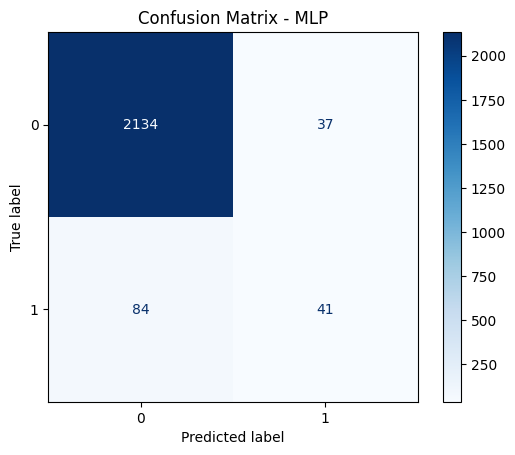

In [55]:
cm = confusion_matrix(y_test1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - MLP")
plt.show()

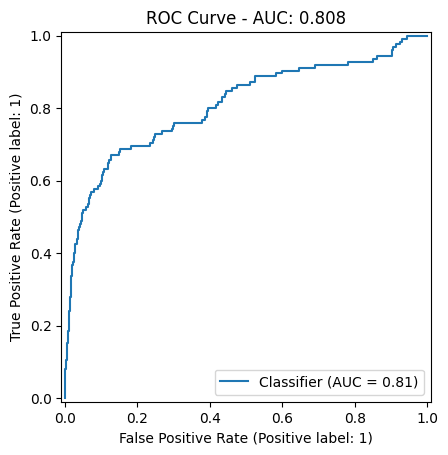

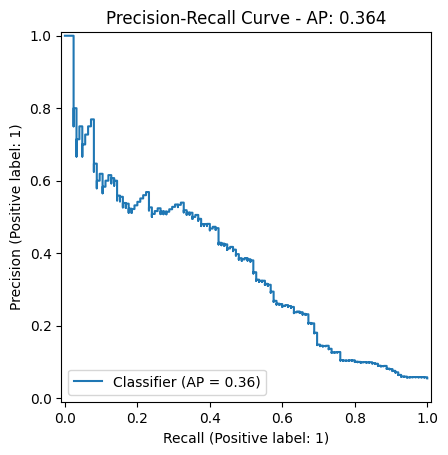

In [56]:
roc_auc = roc_auc_score(y_test1, y_prob)
RocCurveDisplay.from_predictions(y_test1, y_prob)
plt.title(f"ROC Curve - AUC: {roc_auc:.3f}")
plt.show()

ap_score = average_precision_score(y_test1, y_prob)
PrecisionRecallDisplay.from_predictions(y_test1, y_prob)
plt.title(f"Precision-Recall Curve - AP: {ap_score:.3f}")
plt.show()

In [57]:
pipeline_rf = Pipeline([
    ('preprocessing', preprocessor1),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=42)

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report con SMOTE y codificación:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.3f}")

Random Forest Classification Report con SMOTE y codificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2171
           1       0.65      0.09      0.15       125

    accuracy                           0.95      2296
   macro avg       0.80      0.54      0.56      2296
weighted avg       0.93      0.95      0.93      2296

AUC: 0.875
Average Precision: 0.336


                      Feature  Importance
111                num_events    0.236927
114  time_difference(seconds)    0.222098
110                 num_views    0.135145
113               num_scrolls    0.109897
112            num_engagement    0.099279
108           no_availability    0.023042
55              country_Spain    0.018421
70                brand_Apple    0.014500
60     country_United Kingdom    0.013362
65                disp_mobile    0.012420


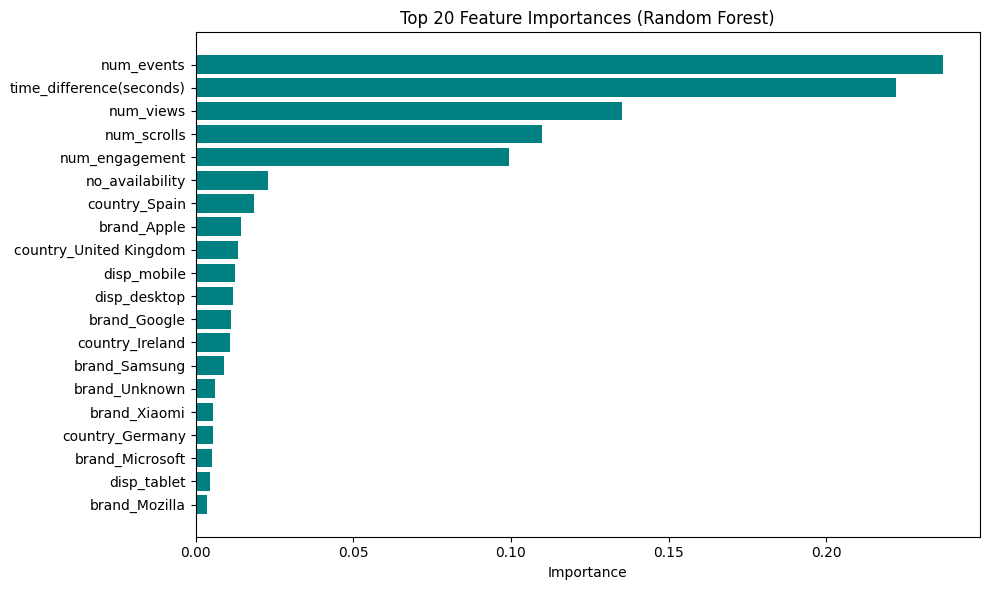

In [58]:
preprocessor = pipeline_rf.named_steps['preprocessing']

def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, cols in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(cols)
            else:
                names = cols
            output_features.extend(names)
        else:
            output_features.extend(cols)
    return output_features

feature_names = get_feature_names(preprocessor)

rf_model = pipeline_rf.named_steps['classifier']
preprocessor = pipeline_rf.named_steps['preprocessing']

feature_names = get_feature_names(preprocessor)

assert len(feature_names) == len(rf_model.feature_importances_)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

top_20 = importance_df.nlargest(20, 'Importance')

plt.figure(figsize=(10, 6))
plt.barh(top_20['Feature'], top_20['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [59]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

X_train, X_test, y_train, y_test = train_test_split(X1, y1, stratify=y1, random_state=42)


pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report con SMOTE y codificación:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.3f}")

c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



Random Forest Classification Report con SMOTE y codificación:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2712
           1       0.32      0.23      0.27       157

    accuracy                           0.93      2869
   macro avg       0.64      0.60      0.62      2869
weighted avg       0.92      0.93      0.93      2869

AUC: 0.872
Average Precision: 0.270


                      Feature  Importance
112  time_difference(seconds)    0.212484
109                num_events    0.186357
111               num_scrolls    0.136088
108                 num_views    0.132917
110            num_engagement    0.104750
53              country_Spain    0.028926
106           no_availability    0.021302
58     country_United Kingdom    0.018400
28            country_Ireland    0.018327
68                brand_Apple    0.015529


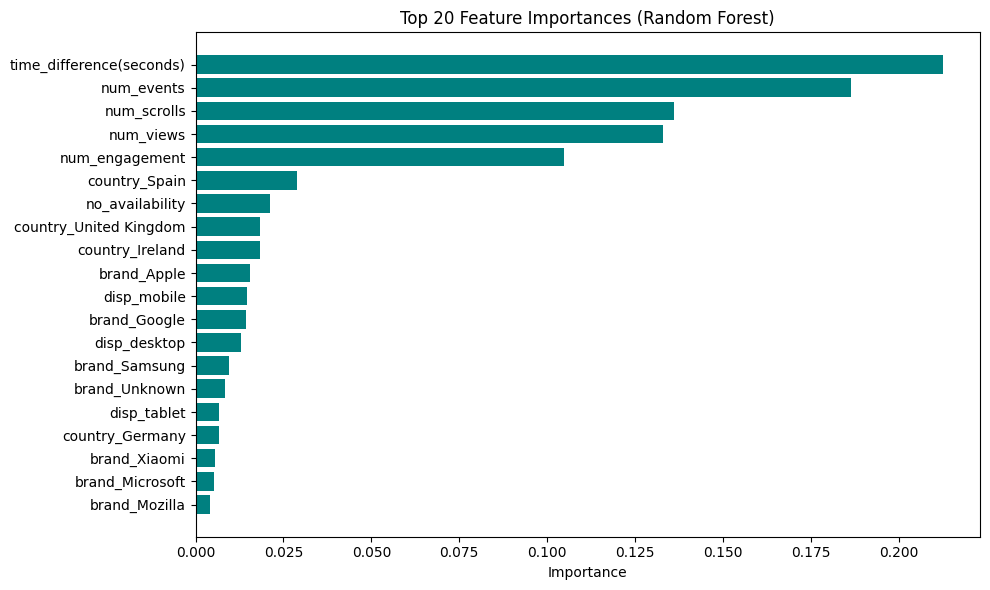

In [60]:
preprocessor = pipeline.named_steps['preprocessing']

def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, cols in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(cols)
            else:
                names = cols
            output_features.extend(names)
        else:
            output_features.extend(cols)
    return output_features

feature_names = get_feature_names(preprocessor)

rf_model = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessing']

feature_names = get_feature_names(preprocessor)

assert len(feature_names) == len(rf_model.feature_importances_)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

top_20 = importance_df.nlargest(20, 'Importance')

plt.figure(figsize=(10, 6))
plt.barh(top_20['Feature'], top_20['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

df_clean = df_model.drop(columns=['user_pseudo_id', 'first_event_date', 'last_event_date'])

categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

X = df_encoded.drop('conversion', axis=1)
y = df_encoded['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

xgb_model = XGBClassifier(scale_pos_weight=20, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.3f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3255
           1       0.37      0.54      0.44       188

    accuracy                           0.93      3443
   macro avg       0.67      0.74      0.70      3443
weighted avg       0.94      0.93      0.93      3443

AUC: 0.903
Average Precision: 0.444


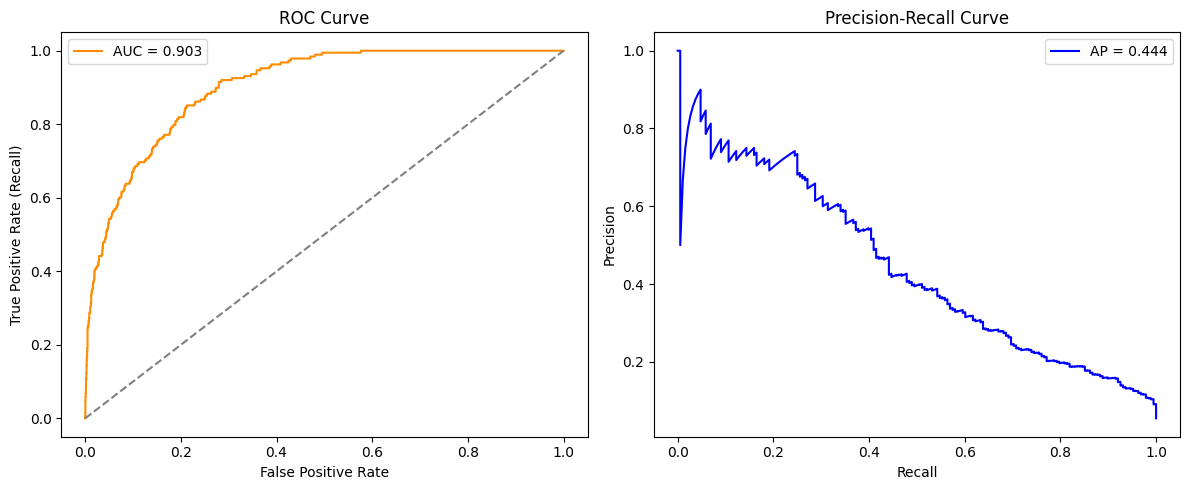

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

y_probs = xgb_model.predict_proba(X_test)[:, 1]

# --- ROC Curve ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()

# --- Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


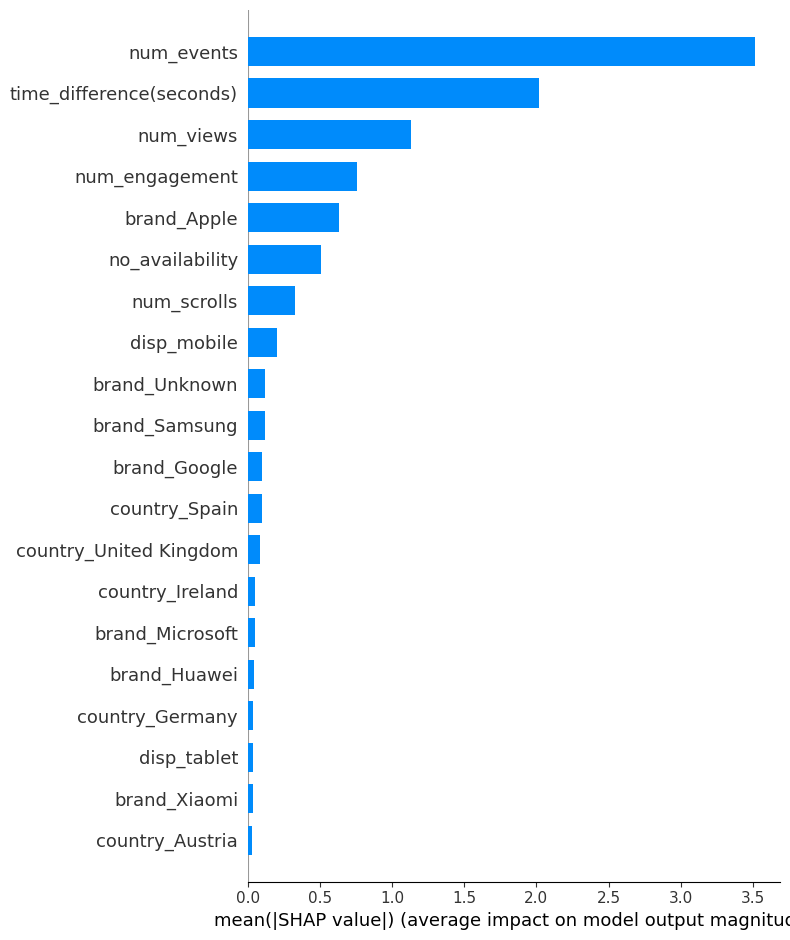

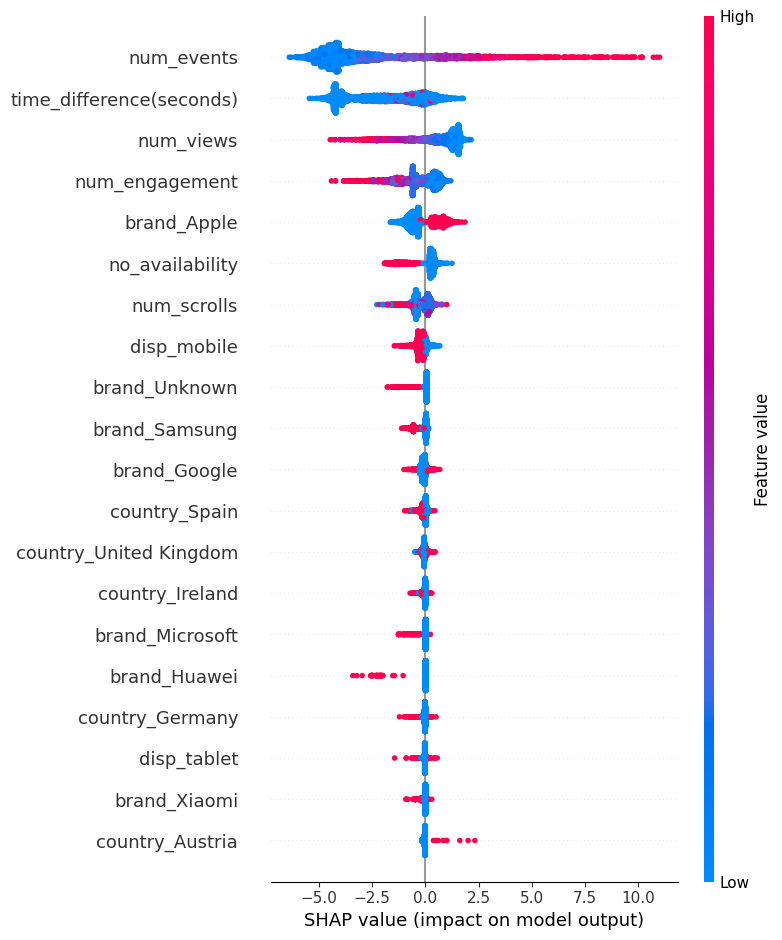

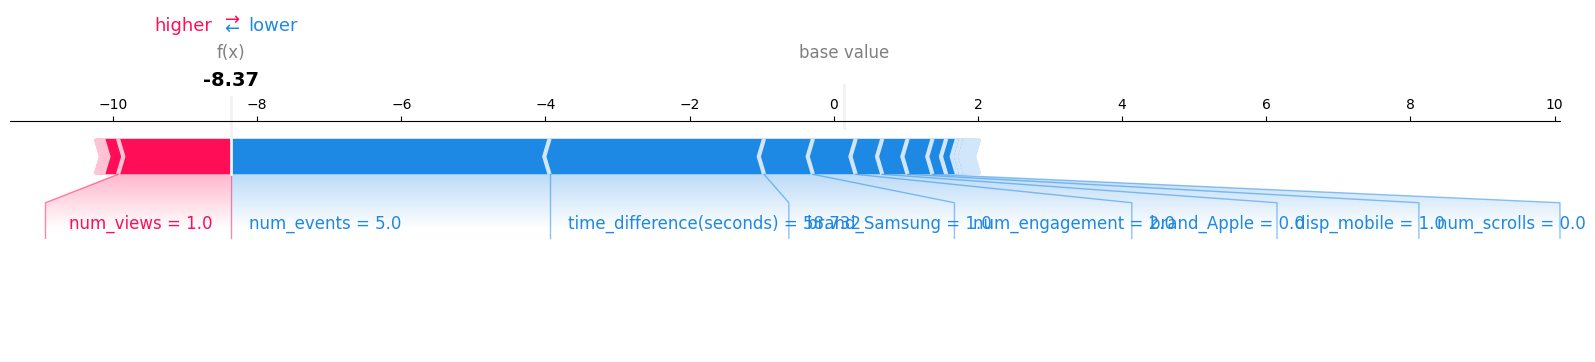

In [63]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_model)  

shap_values = explainer.shap_values(X_test) 

shap.summary_plot(shap_values, X_test, plot_type="bar") 
shap.summary_plot(shap_values, X_test) 

i = 0  
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], matplotlib=True)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

df_clean = df_model.drop(columns=['user_pseudo_id', 'first_event_date', 'last_event_date'])

categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

X = df_clean.drop('conversion', axis=1)
y = df_clean['conversion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
], remainder='passthrough')  

pipeline_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

pipeline_smote.fit(X_train, y_train)

y_pred = pipeline_smote.predict(X_test)
y_proba = pipeline_smote.predict_proba(X_test)[:, 1]

print("Classification Report con Preprocesamiento + SMOTE + XGBoost:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.3f}")

Classification Report con Preprocesamiento + SMOTE + XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3255
           1       0.63      0.37      0.46       188

    accuracy                           0.95      3443
   macro avg       0.80      0.68      0.72      3443
weighted avg       0.95      0.95      0.95      3443

AUC: 0.919
Average Precision: 0.511


c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros

c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown ca

['pipeline_xgb_smote.pkl']

In [90]:
from joblib import dump, load

dump(pipeline_smote, 'pipeline_smote_xgboost.joblib')

['pipeline_smote_xgboost.joblib']

c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



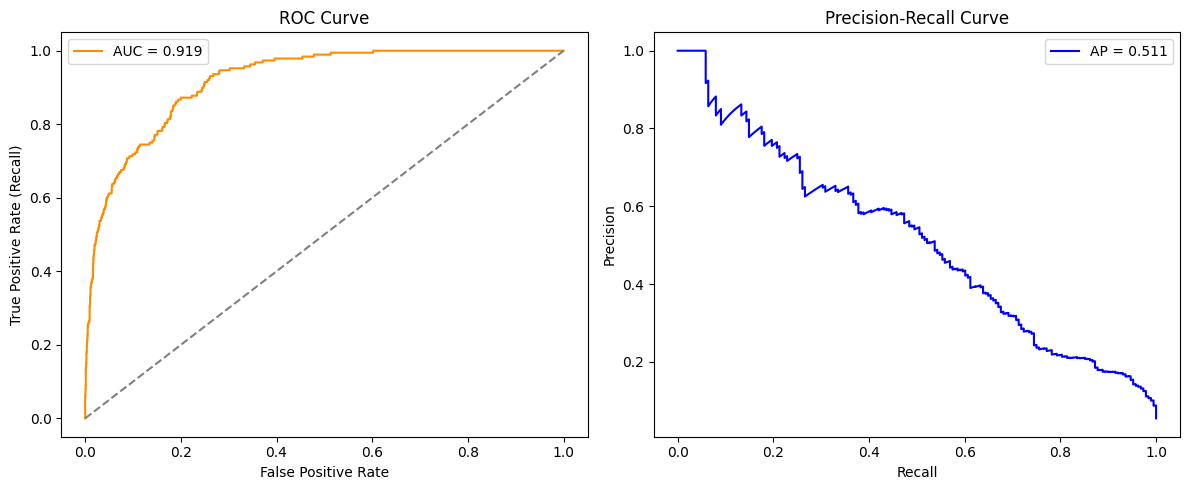

In [128]:
y_probs = pipeline_smote.predict_proba(X_test)[:, 1]

# --- ROC Curve ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()

# --- Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


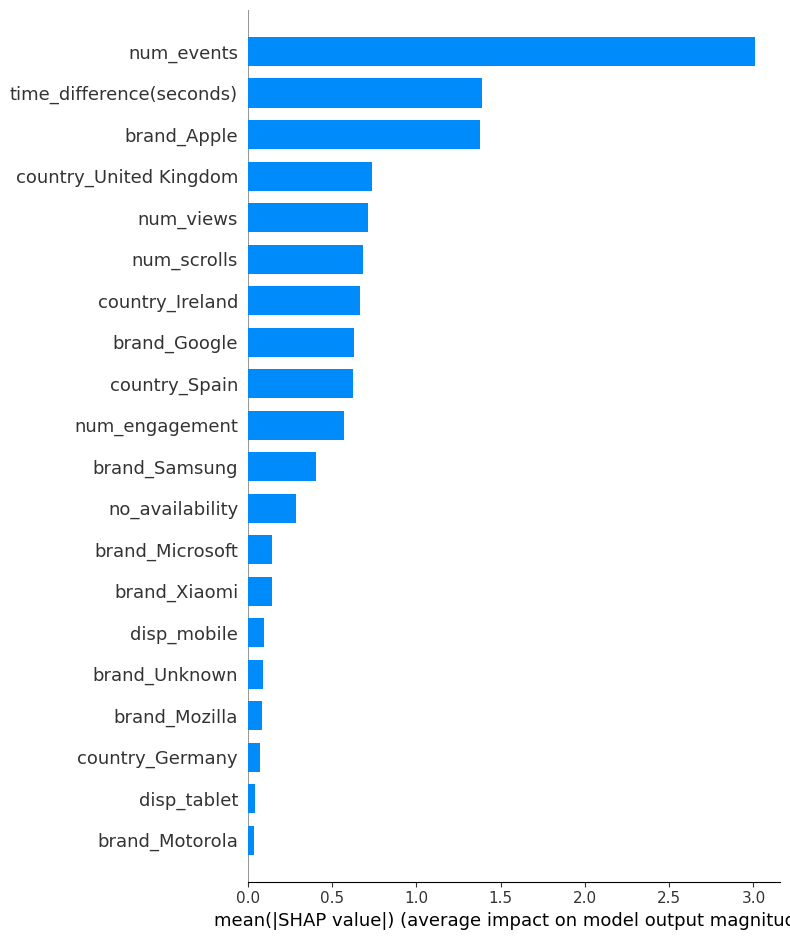

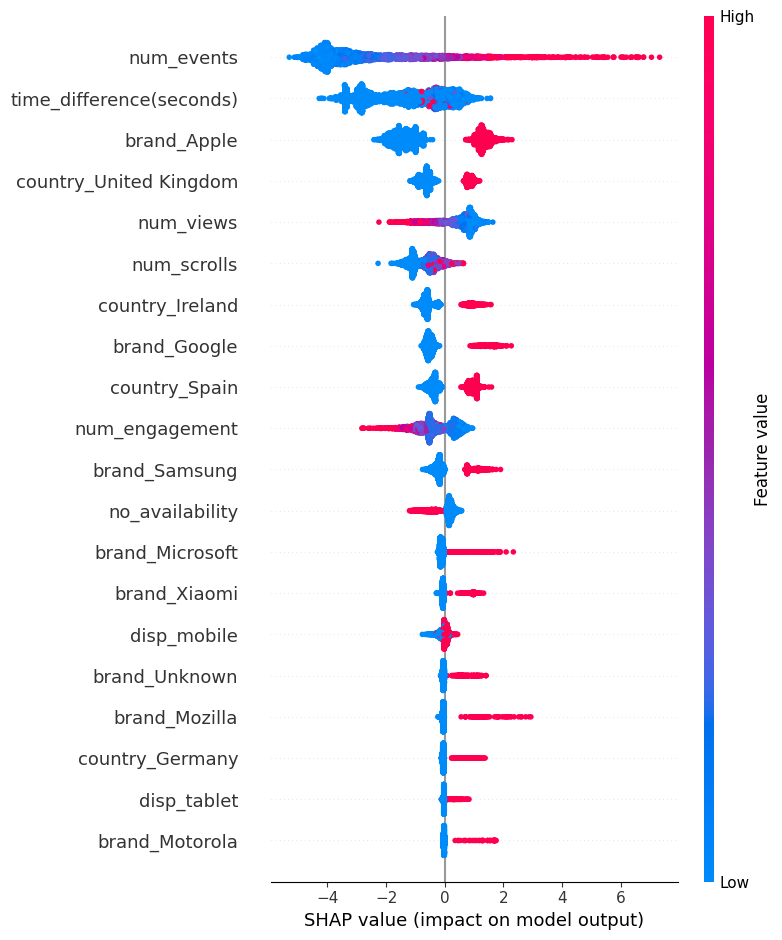

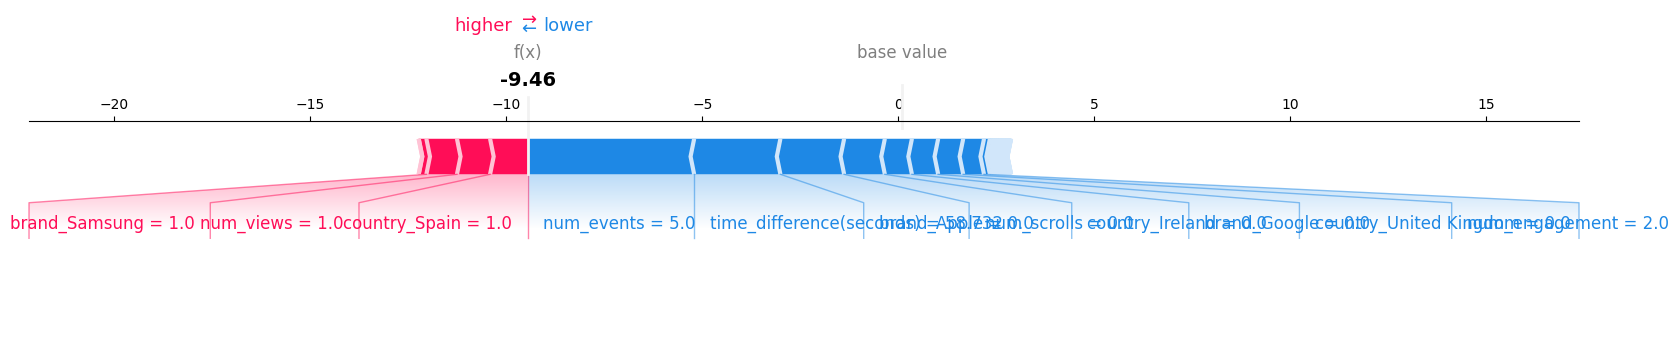

In [67]:
import shap
import matplotlib.pyplot as plt

xgb_model = pipeline_smote.named_steps['xgb']

explainer = shap.TreeExplainer(xgb_model)  

shap_values = explainer.shap_values(X_test)  

shap.summary_plot(shap_values, X_test, plot_type="bar")  # barras
shap.summary_plot(shap_values, X_test)  # beeswarm

i = 0  
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], matplotlib=True)

## Modelo de Segmentación usando KMeans

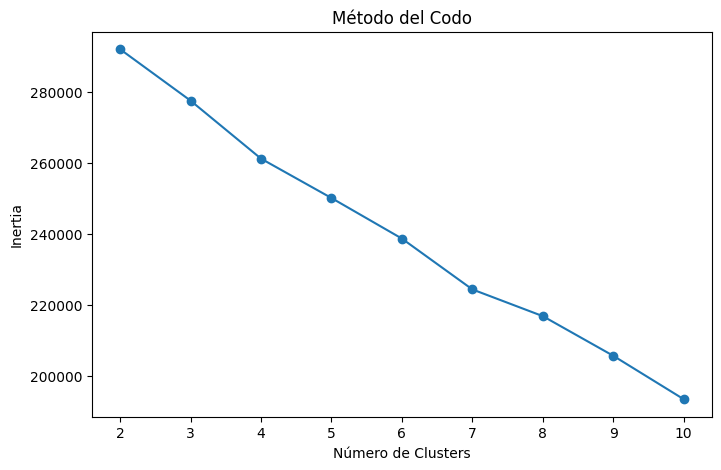

Silhouette Score for k=2: 0.5310
Silhouette Score for k=3: 0.0720
Silhouette Score for k=4: 0.1067
Silhouette Score for k=5: 0.1304
Silhouette Score for k=6: 0.1395
Silhouette Score for k=7: 0.1932
Silhouette Score for k=8: 0.1570
Silhouette Score for k=9: 0.1728
Silhouette Score for k=10: 0.2054
cluster
1    11314
0      162
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cols_num = ['num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']
cols_cat = ['country', 'disp', 'brand']

df_cluster = df_users.copy()

for col in ['country', 'brand']:
    top_values = df_cluster[col].value_counts().nlargest(10).index
    df_cluster[col] = df_cluster[col].where(df_cluster[col].isin(top_values), 'Other')

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat_encoded = encoder.fit_transform(df_cluster[cols_cat])
cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(cols_cat), index=df_cluster.index)

X = pd.concat([df_cluster[cols_num], cat_encoded_df], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.show()
ada k ---
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'Silhouette Score for k={k}: {score:.4f}')

k_opt = 2  # <-- elige según codo + silhouette
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print(df_cluster['cluster'].value_counts())

In [69]:
df_cluster.groupby('cluster')[cols_num + cols_cat].describe()

num_views                                                         \
            count       mean        std   min    25%   50%    75%    max   
cluster                                                                    
0           162.0  53.580247  44.544587  25.0  32.25  41.0  56.75  378.0   
1         11314.0   3.818543   4.206174   0.0   1.00   2.0   5.00   36.0   

        num_events              ... num_scrolls         \
             count        mean  ...         75%    max   
cluster                         ...                      
0            162.0  192.333333  ...       19.75  181.0   
1          11314.0   14.165105  ...        2.00   17.0   

        time_difference(seconds)                                   \
                           count          mean           std  min   
cluster                                                             
0                          162.0  2.943559e+06  7.125996e+06  0.0   
1                        11314.0  4.011963e+05  2.906007e+06  0.0   

                                                               
                 25%          50%           75%           max  
cluster                                                        
0        74382.26875  675764.8775  2.488748e+06  5.747035e+07  
1           23.99600      85.2055  7.090728e+02  6.107320e+07  

[2 rows x 40 columns]

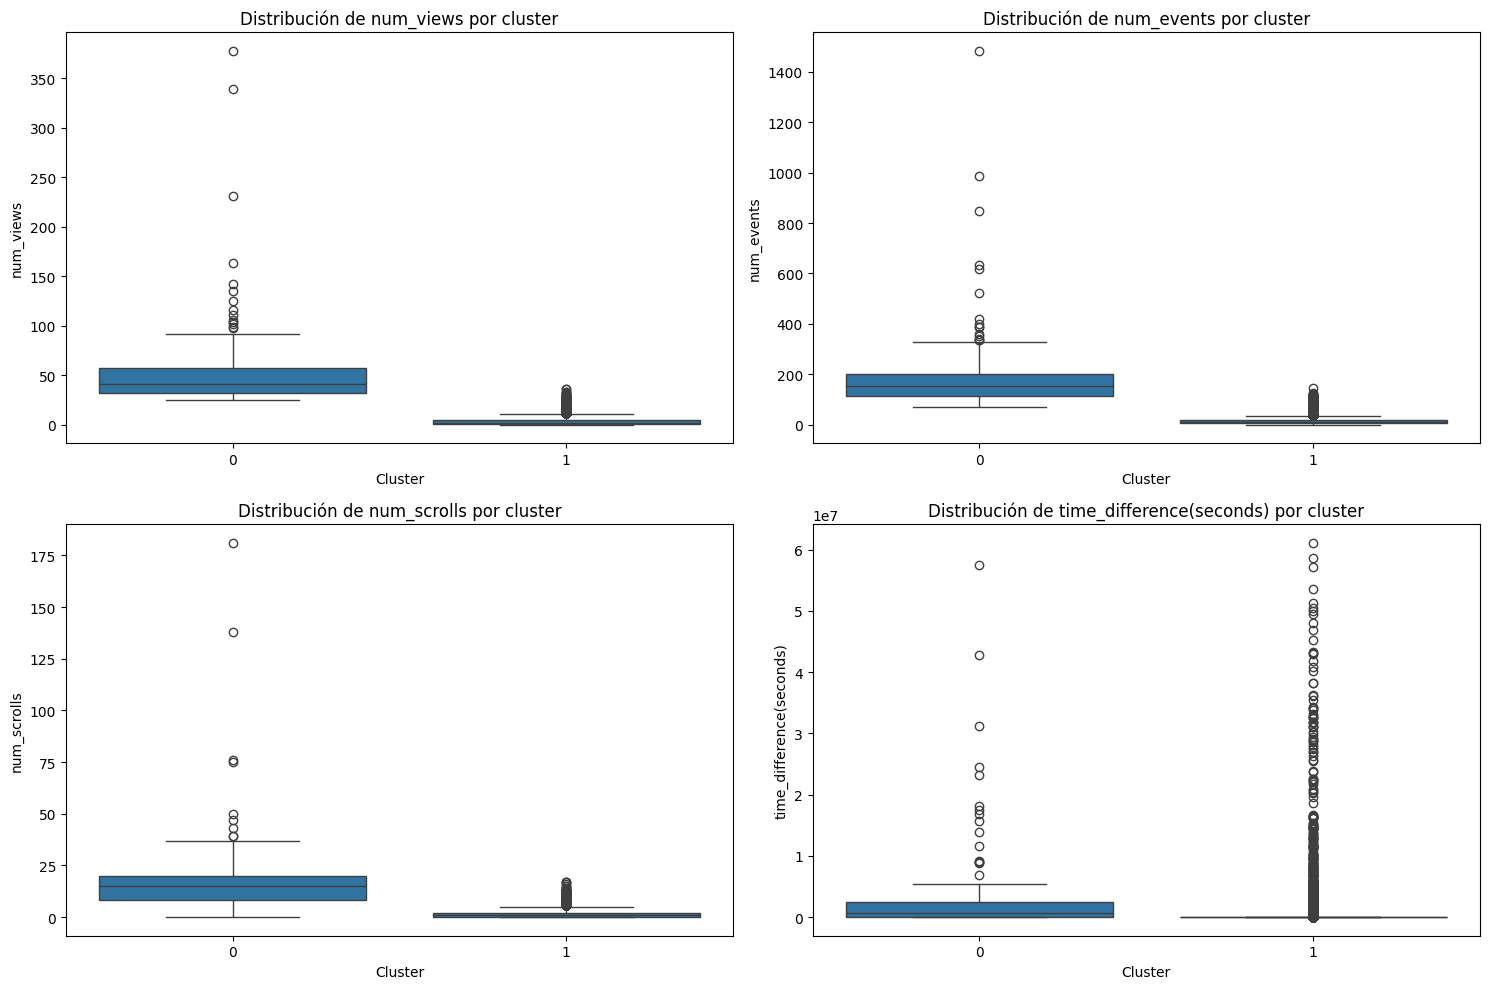

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_plot = ['num_views', 'num_events', 'num_scrolls', 'time_difference(seconds)']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()  # Para iterar fácilmente sobre los ejes

for ax, col in zip(axes, cols_to_plot):
    sns.boxplot(x='cluster', y=col, data=df_cluster, ax=ax)
    ax.set_title(f'Distribución de {col} por cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

In [71]:
for col in ['country', 'brand', 'disp']:
    print(df_cluster.groupby('cluster')[col].value_counts(normalize=False))

cluster  country       
0        United Kingdom      63
         Ireland             59
         Spain               25
         Other                6
         Germany              4
         Netherlands          3
         Italy                1
         Norway               1
1        Spain             4438
         United Kingdom    3549
         Ireland           1906
         Other              383
         Germany            381
         France             167
         Netherlands        164
         Italy              143
         United States       78
         Poland              53
         Norway              52
Name: count, dtype: int64
cluster  brand    
0        Samsung        43
         Apple          41
         Google         34
         Unknown        13
         Microsoft       8
         Other           8
         Xiaomi          7
         Huawei          5
         Motorola        2
         Mozilla         1
1        Apple        4012
         Samsung      2416

In [72]:
df_cluster['conversion'] = df_cluster[['purchase', 'add_to_cart']].any(axis=1).astype(int)
df_cluster.drop(columns=['purchase', 'add_to_cart'], inplace=True)

print(df_cluster.groupby('cluster')['conversion'].mean())

cluster
0    0.481481
1    0.048524
Name: conversion, dtype: float64


## Modelado de add to cart frente a purchase

Ahora vamos a generar un dataset solo de lo que previamente habíamos entendido como conversión, para tratar de entender porque los usuarios que añaden items al carrito finalizan o no su compra. 

In [73]:
df_users

,user_pseudo_id,city,country,disp,brand,purchase,no_availability,refund,add_to_cart,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date
0,1000075147.1736646133,Puerto del Carmen,Spain,mobile,Unknown,False,True,False,False,8.0,38.0,2.0,4.0,19665.369,2025-01-12,2025-01-12
1,1000409496.1736677314,Limerick,Ireland,desktop,Google,False,True,False,False,20.0,96.0,11.0,13.0,48682.067,2025-01-12,2025-01-13
2,1000410660.1734943681,Madrid,Spain,mobile,Xiaomi,False,True,False,False,5.0,18.0,3.0,2.0,72.748,2024-12-23,2024-12-23
3,1000560983.1733155660,Mallow,Ireland,desktop,Apple,False,False,False,False,1.0,2.0,1.0,0.0,0.000,2024-12-02,2024-12-02
4,1000661678.1734282826,Dagenham,United Kingdom,mobile,Apple,False,False,False,False,1.0,5.0,2.0,0.0,9.020,2024-12-15,2024-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11471,998917149.1735450876,Dublin,Ireland,mobile,Samsung,False,True,False,False,7.0,26.0,2.0,4.0,221.310,2024-12-29,2024-12-29
11472,999288322.1737141434,Brussels,Belgium,desktop,Microsoft,False,True,False,False,8.0,33.0,4.0,2.0,0.000,2025-01-17,2025-01-17
11473,999607612.1737224674,Madrid,Spain,mobile,Apple,False,False,False,False,3.0,9.0,1.0,1.0,181.257,2025-01-18,2025-01-18
11474,999655247.1732907158,Selby,United Kingdom,tablet,Amazon,False,False,False,False,5.0,19.0,1.0,2.0,226491.369,2024-12-02,2024-12-02


In [74]:
df_add_enriched = df_add.merge(
    df_users[['user_pseudo_id', 'country', 'brand', 'num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']], 
    on='user_pseudo_id', 
    how='left'
)

df_add_enriched

,user_pseudo_id,event_name,hotelName,room_name,room_code,room_occupancy,check_in,check_out,event_date,time_difference,TotalNights,DaysToCheckIn,mes,country,brand,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds)
0,1930757006.1733045935,add_to_cart,LIVVO Las Gaviotas,Superior Apartment,aptsup,1-1-0,2025-02-14,2025-02-21,2024-12-01,0 days 00:01:10.151000,7,75,2025-02-01,Ireland,Apple,7.0,21.0,3.0,3.0,2.491572e+04
1,1467250310.1733045268,add_to_cart,LIVVO Las Gaviotas,Double Apartment,aptdoble,2-0-0,2025-01-23,2025-01-26,2024-12-01,0 days 00:15:50.472000,3,53,2025-01-01,United Kingdom,Microsoft,24.0,110.0,10.0,11.0,2.968902e+03
2,1467250310.1733045268,add_to_cart,LIVVO Las Gaviotas,Double Apartment,aptdoble,3-0-0,2025-01-23,2025-01-26,2024-12-01,0 days 00:23:00.957000,3,53,2025-01-01,United Kingdom,Microsoft,24.0,110.0,10.0,11.0,2.968902e+03
3,1709362228.1732817811,add_to_cart,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-10-08,2025-10-22,2024-12-01,2 days 16:22:10.043000,14,311,2025-10-01,United Kingdom,Unknown,4.0,32.0,2.0,3.0,2.318699e+05
4,1576563685.1724937259,add_to_cart,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2025-03-14,2025-03-18,2024-12-01,93 days 21:36:06.507000,4,103,2025-03-01,Ireland,Samsung,48.0,186.0,23.0,26.0,1.156415e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,1281051844.1739121667,add_to_cart,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2025-09-25,2025-10-02,2025-02-09,0 days 00:06:44.471000,7,228,2025-09-01,Ireland,Microsoft,9.0,54.0,4.0,1.0,2.474970e+03
795,1327684706.1738863756,add_to_cart,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-2-0,2025-03-01,2025-03-02,2025-02-09,3 days 01:50:08.899000,1,20,2025-03-01,United Kingdom,Microsoft,17.0,79.0,8.0,4.0,2.661292e+05
796,1249386008.1739131611,add_to_cart,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-10-09,2025-10-22,2025-02-09,0 days 00:01:03.444000,13,242,2025-10-01,United Kingdom,Apple,4.0,20.0,0.0,1.0,1.179639e+03
797,64252549.1739132259,add_to_cart,LIVVO Las Gaviotas,Apartamento Doble (2 Dormitorios),aptdoble,2-2-0,2025-08-02,2025-08-09,2025-02-09,0 days 00:02:29.962000,7,174,2025-08-01,France,Apple,6.0,19.0,6.0,2.0,6.073740e+02


In [75]:
df_purchase_enriched = df_purchase.merge(
    df_users[['user_pseudo_id', 'country', 'brand', 'num_views', 'num_events', 'num_engagement', 'num_scrolls', 'time_difference(seconds)']], 
    on='user_pseudo_id', 
    how='left'
)

df_purchase_enriched.drop(columns=['valor', 'price_per_night'], inplace=True)

df_purchase_enriched

,user_pseudo_id,event_name,hotelName,room_name,room_code,room_occupancy,check_in,check_out,event_date,time_difference,TotalNights,DaysToCheckIn,mes,country,brand,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds)
0,151982344.1732715181,purchase,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2024-11-30,2024-12-07,2024-12-01,3 days 19:53:23.417000,7,-1,2024-11-01,Spain,Google,231.0,846.0,98.0,28.0,3.226696e+06
1,1631356880.1721985482,purchase,LIVVO Las Gaviotas,Apartamento Superior,aptsup,2-0-0,2025-03-16,2025-03-25,2024-12-02,129 days 00:09:07.451000,9,104,2025-03-01,Spain,Google,15.0,71.0,9.0,5.0,1.114664e+07
2,533248603.1733139931,purchase,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-2-0,2025-02-12,2025-02-19,2024-12-02,0 days 01:12:17.665000,7,72,2025-02-01,United Kingdom,Google,51.0,237.0,29.0,20.0,4.459778e+05
3,1076425916.1732130798,purchase,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-03-16,2025-03-23,2024-12-02,11 days 18:14:33.829000,7,104,2025-03-01,United Kingdom,Apple,59.0,134.0,30.0,2.0,1.815508e+06
4,547625027.1732887558,purchase,Hotel LIVVO Lumm,Doble Estándar,dbl,1-0-0,2024-12-09,2024-12-10,2024-12-02,3 days 01:16:28.729000,1,7,2024-12-01,Spain,Microsoft,1.0,6.0,1.0,1.0,2.640680e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,100102787.1737560920,purchase,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-06-06,2025-06-16,2025-02-07,15 days 22:44:05.516000,10,119,2025-06-01,Ireland,Google,15.0,66.0,9.0,3.0,1.377863e+06
163,694310412.1738969083,purchase,LIVVO Las Gaviotas,Superior Apartment,aptsup,2-0-0,2025-04-10,2025-04-14,2025-02-08,0 days 00:59:36.282000,4,61,2025-04-01,Ireland,Xiaomi,30.0,174.0,17.0,15.0,4.945960e+04
164,1782557784.1739031007,purchase,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-0-0,2026-01-01,2026-01-07,2025-02-08,0 days 00:18:26.992000,6,327,2026-01-01,United Kingdom,Samsung,9.0,58.0,1.0,5.0,1.161426e+03
165,1327684706.1738863756,purchase,LIVVO Las Gaviotas,Standard Apartment Plus,aptstdplus,2-2-0,2025-03-01,2025-03-02,2025-02-09,3 days 01:55:18.404000,1,20,2025-03-01,United Kingdom,Microsoft,17.0,79.0,8.0,4.0,2.661292e+05


In [76]:
df_combined = pd.concat([df_purchase_enriched, df_add_enriched])
df_combined = df_combined.drop_duplicates(subset='user_pseudo_id', keep='first')

In [77]:
df_combined['purchase'] = (df_combined['event_name'] == 'purchase').astype(int)
df_combined.drop(columns=['user_pseudo_id','event_name', 'room_name','check_in', 'check_out', 'event_date', 'mes', 'time_difference(seconds)'], inplace=True)
df_combined

,hotelName,room_code,room_occupancy,time_difference,TotalNights,DaysToCheckIn,country,brand,num_views,num_events,num_engagement,num_scrolls,purchase
0,LIVVO Las Gaviotas,aptstdplus,2-0-0,3 days 19:53:23.417000,7,-1,Spain,Google,231.0,846.0,98.0,28.0,1
1,LIVVO Las Gaviotas,aptsup,2-0-0,129 days 00:09:07.451000,9,104,Spain,Google,15.0,71.0,9.0,5.0,1
2,LIVVO Las Gaviotas,aptsup,2-2-0,0 days 01:12:17.665000,7,72,United Kingdom,Google,51.0,237.0,29.0,20.0,1
3,LIVVO Las Gaviotas,aptsup,2-0-0,11 days 18:14:33.829000,7,104,United Kingdom,Apple,59.0,134.0,30.0,2.0,1
4,Hotel LIVVO Lumm,dbl,1-0-0,3 days 01:16:28.729000,1,7,Spain,Microsoft,1.0,6.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,LIVVO Las Gaviotas,aptstdplus,2-0-0,0 days 00:43:08.647000,8,87,United Kingdom,Apple,7.0,29.0,7.0,2.0,0
793,LIVVO Las Gaviotas,aptstdplus,2-0-0,0 days 00:00:52.199000,1,2,United Kingdom,Apple,1.0,7.0,0.0,1.0,0
794,LIVVO Las Gaviotas,aptstdplus,2-0-0,0 days 00:06:44.471000,7,228,Ireland,Microsoft,9.0,54.0,4.0,1.0,0
796,LIVVO Las Gaviotas,aptsup,2-0-0,0 days 00:01:03.444000,13,242,United Kingdom,Apple,4.0,20.0,0.0,1.0,0


In [78]:
df_combined['time_difference_seconds'] = df_combined['time_difference'].dt.total_seconds()

In [79]:
df_combined.drop(columns=['time_difference'], inplace=True)
df_combined.head()

,hotelName,room_code,room_occupancy,TotalNights,DaysToCheckIn,country,brand,num_views,num_events,num_engagement,num_scrolls,purchase,time_difference_seconds
0,LIVVO Las Gaviotas,aptstdplus,2-0-0,7,-1,Spain,Google,231.0,846.0,98.0,28.0,1,3.308034e+05
1,LIVVO Las Gaviotas,aptsup,2-0-0,9,104,Spain,Google,15.0,71.0,9.0,5.0,1,1.114615e+07
2,LIVVO Las Gaviotas,aptsup,2-2-0,7,72,United Kingdom,Google,51.0,237.0,29.0,20.0,1,4.337665e+03
3,LIVVO Las Gaviotas,aptsup,2-0-0,7,104,United Kingdom,Apple,59.0,134.0,30.0,2.0,1,1.016074e+06
4,Hotel LIVVO Lumm,dbl,1-0-0,1,7,Spain,Microsoft,1.0,6.0,1.0,1.0,1,2.637887e+05


In [80]:
target_col = 'purchase'

categorical_cols = df_combined.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_combined.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

df_encoded = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

xgb_model = XGBClassifier(scale_pos_weight=10, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.3f}")

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       142
           1       0.63      0.68      0.65        47

    accuracy                           0.82       189
   macro avg       0.76      0.77      0.77       189
weighted avg       0.83      0.82      0.82       189

AUC: 0.885
Average Precision: 0.761


In [81]:
from sklearn.metrics import (
    accuracy_score,
    matthews_corrcoef,
    cohen_kappa_score,
    log_loss,
    brier_score_loss
)

# Asegúrate de tener y_test, y_pred, y_proba definidos

print("✅ Otras métricas de evaluación:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Matthews Correlation Coefficient (MCC): {matthews_corrcoef(y_test, y_pred):.3f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"Log Loss: {log_loss(y_test, y_proba):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_proba):.3f}")

✅ Otras métricas de evaluación:
Accuracy: 0.820
Matthews Correlation Coefficient (MCC): 0.533
Cohen's Kappa: 0.532
Log Loss: 0.477
Brier Score: 0.129


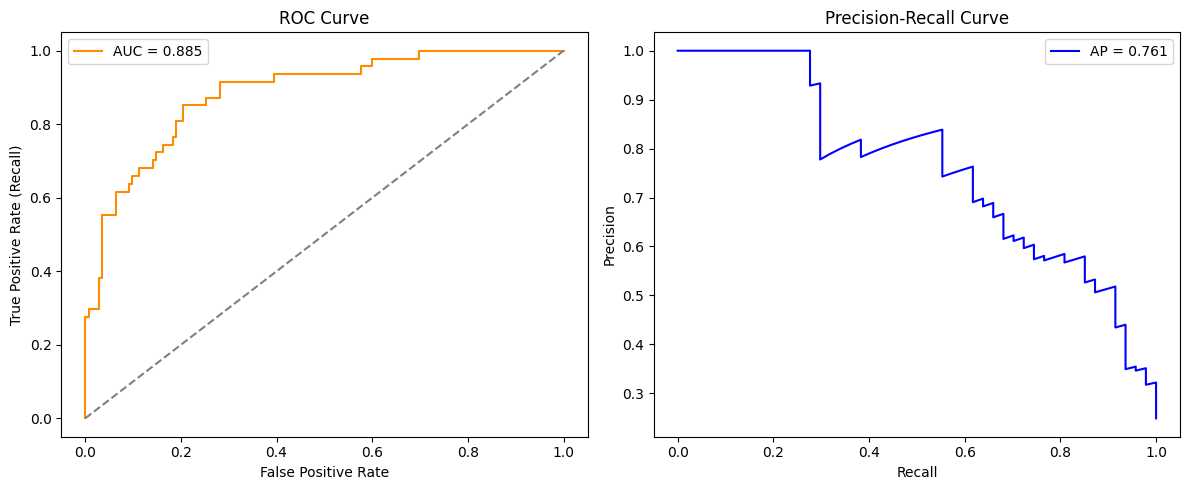

In [82]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# --- ROC Curve ---
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()

# --- Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

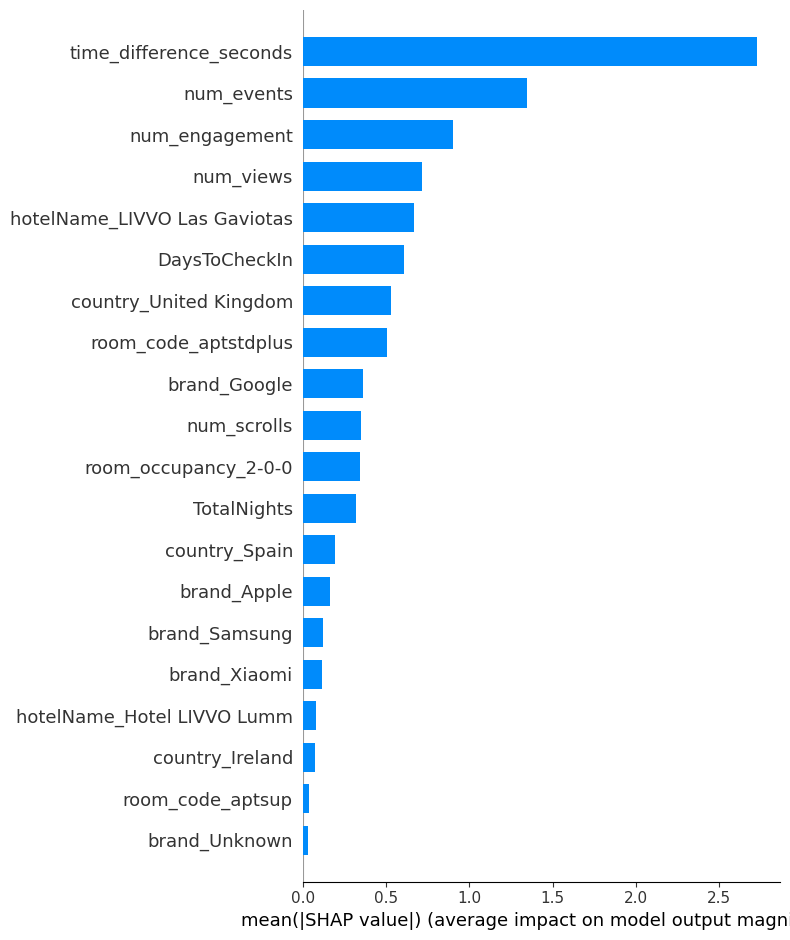

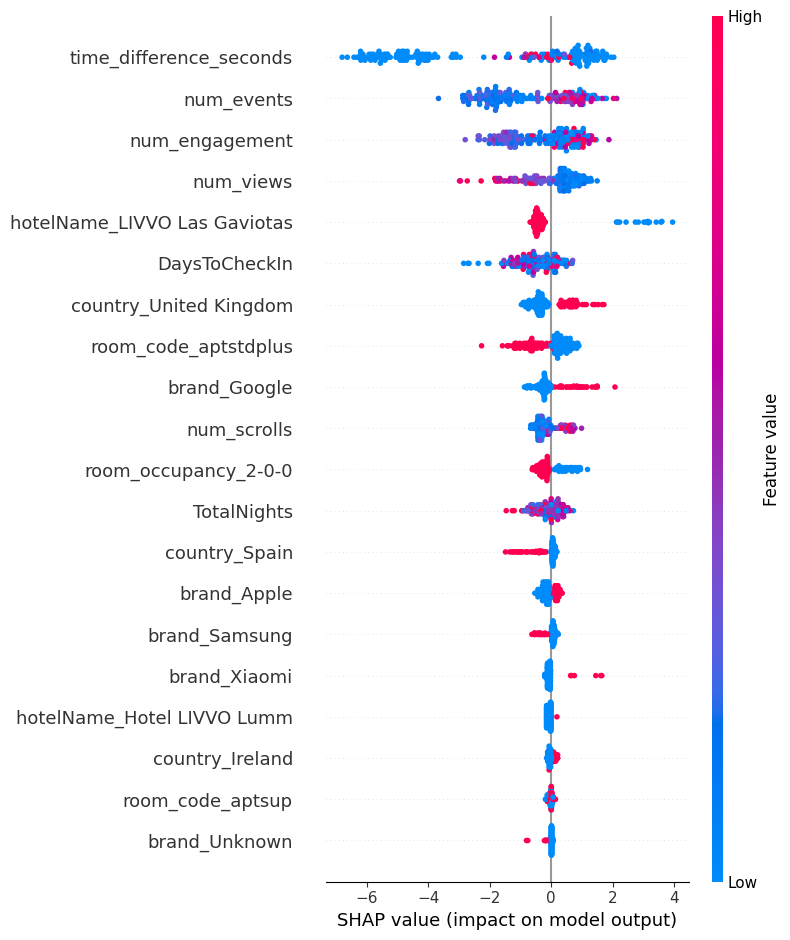

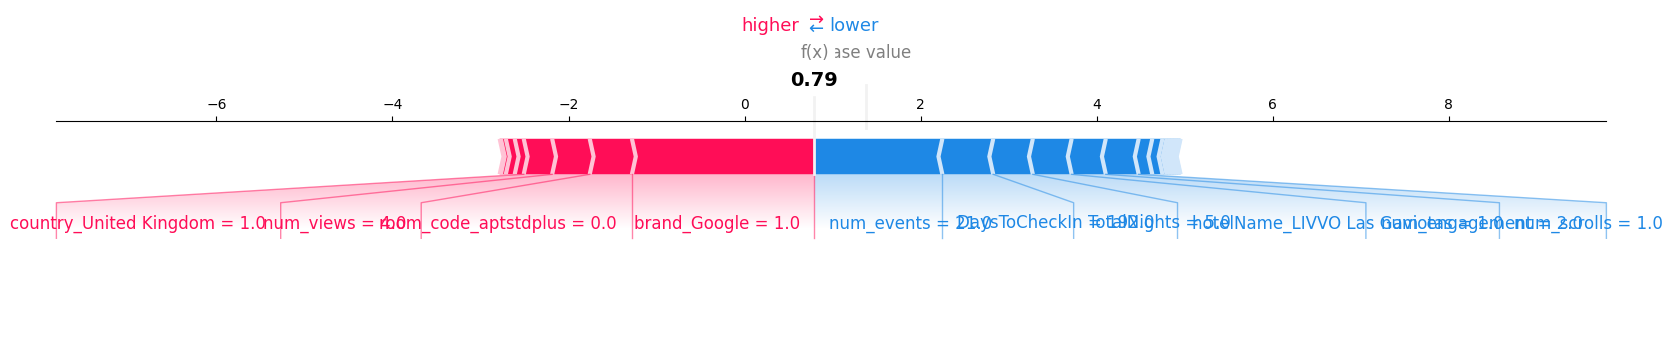

In [83]:

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

i = 0
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], matplotlib=True)

# Intento de procesamiento de eventos de cancelación

In [84]:
df_refund = df_processed[df_processed['event_name'] == 'refund']
df_refund

,event_date,event_timestamp,event_name,event_params,event_bundle_sequence_id,user_pseudo_id,privacy_info,user_first_touch_timestamp,user_ltv,device,...,city,country,num_views,num_clicks,num_engagement,num_scrolls,num_events,disp,brand,country_grouped
18304,20241202,2024-12-02 09:32:35.555,refund,"{""v"":[{""v"":{""f"":[{""v"":""hotelCode""},{""v"":{""f"":[...",982470027,1631356880.1721985482,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-07-26 09:18:08.172,"{""v"":{""f"":[{""v"":""1221.010332""},{""v"":""USD""}]}}","{""v"":{""f"":[{""v"":""desktop""},{""v"":""Google""},{""v""...",...,Donostia-San Sebastian,Spain,15.0,0.0,9.0,5.0,71.0,desktop,Google,Spain
155671,20241202,2024-12-02 09:32:36.823,refund,"{""v"":[{""v"":{""f"":[{""v"":""hotelCode""},{""v"":{""f"":[...",983737382,1631356880.1721985482,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-07-26 09:18:08.172,"{""v"":{""f"":[{""v"":""1221.010332""},{""v"":""USD""}]}}","{""v"":{""f"":[{""v"":""desktop""},{""v"":""Google""},{""v""...",...,Donostia-San Sebastian,Spain,15.0,0.0,9.0,5.0,71.0,desktop,Google,Spain
144033,20241205,2024-12-05 18:00:55.661,refund,"{""v"":[{""v"":{""f"":[{""v"":""userType""},{""v"":{""f"":[{...",-1375199881,50843426.1733421639,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-12-05 18:00:38.822,None,"{""v"":{""f"":[{""v"":""mobile""},{""v"":""Apple""},{""v"":""...",...,Frankfurt,Germany,1.0,0.0,1.0,0.0,6.0,mobile,Apple,Germany
136116,20241213,2024-12-13 08:41:52.802,refund,"{""v"":[{""v"":{""f"":[{""v"":""ga_session_number""},{""v...",-848055615,1398981732.1733432767,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-12-05 21:06:10.610,None,"{""v"":{""f"":[{""v"":""desktop""},{""v"":""Microsoft""},{...",...,Angers,France,2.0,0.0,2.0,1.0,14.0,desktop,Microsoft,France
95714,20241214,2024-12-14 22:50:50.173,refund,"{""v"":[{""v"":{""f"":[{""v"":""engagement_time_msec""},...",-949637827,1564929070.1732828073,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-11-28 21:07:53.922,None,"{""v"":{""f"":[{""v"":""desktop""},{""v"":""Apple""},{""v"":...",...,Vitoria-Gasteiz,Spain,1.0,0.0,1.0,0.0,8.0,desktop,Apple,Spain
207230,20241217,2024-12-17 14:36:46.455,refund,"{""v"":[{""v"":{""f"":[{""v"":""hotelName""},{""v"":{""f"":[...",973377003,1213923254.1734445857,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-12-17 14:30:55.961,None,"{""v"":{""f"":[{""v"":""desktop""},{""v"":""Google""},{""v""...",...,Madrid,Spain,1.0,0.0,1.0,0.0,7.0,desktop,Google,Spain
170899,20241220,2024-12-20 17:54:20.517,refund,"{""v"":[{""v"":{""f"":[{""v"":""page_location""},{""v"":{""...",1444499568,747254279.1734534533,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-12-18 15:08:52.875,"{""v"":{""f"":[{""v"":""3086.709344""},{""v"":""USD""}]}}","{""v"":{""f"":[{""v"":""mobile""},{""v"":""Apple""},{""v"":""...",...,London,United Kingdom,1.0,0.0,1.0,0.0,3.0,mobile,Apple,United Kingdom
283460,20241221,2024-12-21 08:33:14.936,refund,"{""v"":[{""v"":{""f"":[{""v"":""userType""},{""v"":{""f"":[{...",-1655656087,891166245.1734769940,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2024-12-21 08:32:20.115,None,"{""v"":{""f"":[{""v"":""desktop""},{""v"":""Microsoft""},{...",...,Vantaa,Finland,1.0,0.0,1.0,0.0,9.0,desktop,Microsoft,Other
190042,20241221,2024-12-21 11:08:38.392,refund,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",-922135302,606445324.1700649190,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2023-11-22 10:28:00.356,"{""v"":{""f"":[{""v"":""1230.925436""},{""v"":""USD""}]}}","{""v"":{""f"":[{""v"":""mobile""},{""v"":null},{""v"":null...",...,Las Palmas de Gran Canaria,Spain,17.0,0.0,2.0,9.0,85.0,mobile,None,Spain
159000,20241221,2024-12-21 11:08:39.499,refund,"{""v"":[{""v"":{""f"":[{""v"":""engaged_session_event""}...",-921027923,606445324.1700649190,"{""v"":{""f"":[{""v"":null},{""v"":null},{""v"":""No""}]}}",2023-11-22 10:28

In [85]:
from files.constants import *

df_refund_data = apply_event_param_parsing(df_refund)


In [94]:
df_refund_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 18304 to 242301
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   hotelCode              28 non-null     object         
 1   userType               28 non-null     object         
 2   batch_page_id          28 non-null     object         
 3   ga_session_id          28 non-null     object         
 4   ga_session_number      28 non-null     object         
 5   page_title             28 non-null     object         
 6   engagement_time_msec   28 non-null     object         
 7   hotelName              24 non-null     object         
 8   session_engaged        28 non-null     object         
 9   engaged_session_event  28 non-null     object         
 10  page_location          28 non-null     object         
 11  batch_ordering_id      28 non-null     object         
 12  transaction_id         7 non-null      object    

In [95]:
from files.process_purchase import enrich_with_item_data

df_all_refund=enrich_with_item_data(df_refund_data)

In [96]:
df_all_refund

,hotelCode,userType,batch_page_id,ga_session_id,ga_session_number,page_title,engagement_time_msec,hotelName,session_engaged,engaged_session_event,...,user_pseudo_id,event_date,items,time_difference,room_code,room_name,room_occupancy,check_in,check_out,valor
18304,[aptlasgaviotas],[Registered],[1733131913592],[1733131073],[5],[¡Reserva al mejor precio garantizado!],[14314],[Apartments Las Gaviotas],[1],[1],...,1631356880.1721985482,20241202,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",129 days 00:14:27.383000,(not set),(not set),(not set),(not set),(not set),None
155671,[aptlasgaviotas],[Registered],[1733131913592],[1733131073],[5],[¡Reserva al mejor precio garantizado!],[12],[Apartments Las Gaviotas],[1],[1],...,1631356880.1721985482,20241202,"{""v"":[]}",129 days 00:14:28.651000,None,None,None,None,None,None
144033,[aptlasgaviotas],[None],[1733421637993],[1733421638],[1],[Book at the best price guaranteed!],[7525],[Hotel LIVVO Lumm],[0],[1],...,50843426.1733421639,20241205,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",0 days 00:00:16.839000,(not set),(not set),(not set),(not set),(not set),None
136116,[aptlasgaviotas],[Registered],[1734079275843],[1734079281],[4],[Réservez au meilleur prix garanti!],[23040],[Hotel LIVVO Lumm],[1],[1],...,1398981732.1733432767,20241213,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",7 days 11:35:42.192000,(not set),(not set),(not set),(not set),(not set),None
95714,[aptlasgaviotas],[None],[1734216621033],[1734216622],[3],[¡Reserva al mejor precio garantizado!],[22786],NaN,[1],[1],...,1564929070.1732828073,20241214,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",16 days 01:42:56.251000,(not set),(not set),(not set),(not set),(not set),None
207230,[aptlasgaviotas],[Registered],[1734446174795],[1734445857],[1],[¡Reserva al mejor precio garantizado!],[23085],[Hotel LIVVO Koala Garden],[1],[1],...,1213923254.1734445857,20241217,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",0 days 00:05:50.494000,(not set),(not set),(not set),(not set),(not set),None
170899,[aptlasgaviotas],[Registered],[1734717218463],[1734717173],[5],[Book at the best price guaranteed!],[40793],[Hotel LIVVO Volcán Lanzarote],[1],[1],...,747254279.1734534533,20241220,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",2 days 02:45:27.642000,(not set),(not set),(not set),(not set),(not set),None
283460,[aptlasgaviotas],[None],[1734769939346],[1734769940],[1],[Book at the best price guaranteed!],[24909],[Hotel LIVVO Fataga],[1],[1],...,891166245.1734769940,20241221,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",0 days 00:00:54.821000,(not set),(not set),(not set),(not set),(not set),None
190042,[aptlasgaviotas],[Registered],[1734779287204],[1734779088],[36],[¡Reserva al mejor precio garantizado!],[26278],[Apartamentos LIVVO Las Gaviotas],[1],[1],...,606445324.1700649190,20241221,"{""v"":[{""v"":{""f"":[{""v"":""(not set)""},{""v"":""(not ...",395 days 00:40:38.036000,(not set),(not set),(not set),(not set),(not set),None
159000,[aptlasgaviotas],[Registered],[1734779287204],[1734779088],[36],[¡Reserva al mejor precio garantizado!],[18],[Apartamentos LIVVO Las Gaviotas],[1],[1],...,606445324.1700649190,20241221,"{""v"":[]}",395 days 00:40:39.143000,None,None,None,None,None,None


In [98]:
df_users

,user_pseudo_id,city,country,disp,brand,purchase,no_availability,refund,add_to_cart,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date
0,1000075147.1736646133,Puerto del Carmen,Spain,mobile,Unknown,False,True,False,False,8.0,38.0,2.0,4.0,19665.369,2025-01-12,2025-01-12
1,1000409496.1736677314,Limerick,Ireland,desktop,Google,False,True,False,False,20.0,96.0,11.0,13.0,48682.067,2025-01-12,2025-01-13
2,1000410660.1734943681,Madrid,Spain,mobile,Xiaomi,False,True,False,False,5.0,18.0,3.0,2.0,72.748,2024-12-23,2024-12-23
3,1000560983.1733155660,Mallow,Ireland,desktop,Apple,False,False,False,False,1.0,2.0,1.0,0.0,0.000,2024-12-02,2024-12-02
4,1000661678.1734282826,Dagenham,United Kingdom,mobile,Apple,False,False,False,False,1.0,5.0,2.0,0.0,9.020,2024-12-15,2024-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11471,998917149.1735450876,Dublin,Ireland,mobile,Samsung,False,True,False,False,7.0,26.0,2.0,4.0,221.310,2024-12-29,2024-12-29
11472,999288322.1737141434,Brussels,Belgium,desktop,Microsoft,False,True,False,False,8.0,33.0,4.0,2.0,0.000,2025-01-17,2025-01-17
11473,999607612.1737224674,Madrid,Spain,mobile,Apple,False,False,False,False,3.0,9.0,1.0,1.0,181.257,2025-01-18,2025-01-18
11474,999655247.1732907158,Selby,United Kingdom,tablet,Amazon,False,False,False,False,5.0,19.0,1.0,2.0,226491.369,2024-12-02,2024-12-02


In [123]:
usu = df_users[df_users['purchase'] == False]
usuarios_sin_conversion = usu[usu['add_to_cart'] == False]

In [124]:
usuarios_sin_conversion

,user_pseudo_id,city,country,disp,brand,purchase,no_availability,refund,add_to_cart,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date
0,1000075147.1736646133,Puerto del Carmen,Spain,mobile,Unknown,False,True,False,False,8.0,38.0,2.0,4.0,19665.369,2025-01-12,2025-01-12
1,1000409496.1736677314,Limerick,Ireland,desktop,Google,False,True,False,False,20.0,96.0,11.0,13.0,48682.067,2025-01-12,2025-01-13
2,1000410660.1734943681,Madrid,Spain,mobile,Xiaomi,False,True,False,False,5.0,18.0,3.0,2.0,72.748,2024-12-23,2024-12-23
3,1000560983.1733155660,Mallow,Ireland,desktop,Apple,False,False,False,False,1.0,2.0,1.0,0.0,0.000,2024-12-02,2024-12-02
4,1000661678.1734282826,Dagenham,United Kingdom,mobile,Apple,False,False,False,False,1.0,5.0,2.0,0.0,9.020,2024-12-15,2024-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11471,998917149.1735450876,Dublin,Ireland,mobile,Samsung,False,True,False,False,7.0,26.0,2.0,4.0,221.310,2024-12-29,2024-12-29
11472,999288322.1737141434,Brussels,Belgium,desktop,Microsoft,False,True,False,False,8.0,33.0,4.0,2.0,0.000,2025-01-17,2025-01-17
11473,999607612.1737224674,Madrid,Spain,mobile,Apple,False,False,False,False,3.0,9.0,1.0,1.0,181.257,2025-01-18,2025-01-18
11474,999655247.1732907158,Selby,United Kingdom,tablet,Amazon,False,False,False,False,5.0,19.0,1.0,2.0,226491.369,2024-12-02,2024-12-02


In [125]:
from files.execution import predict

df_prediction=predict(usuarios_sin_conversion)

df_prediction_sorted = df_prediction.sort_values(by='probabilidad_conversion', ascending=False)
df_prediction_sorted

c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros

c:\Users\reyme\anaconda3\envs\PLN\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\execution.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\reyme\OneDrive\Documentos\Cuarto curso\Practicas Golubo\gaviotas_tablas\files\execution.py:65: SettingWithCopyWarning:


A value is trying to be set on a

,user_pseudo_id,city,country,disp,brand,purchase,no_availability,refund,add_to_cart,num_views,num_events,num_engagement,num_scrolls,time_difference(seconds),first_event_date,last_event_date,prediccion_conversión,probabilidad_conversion
1042,1175050590.1737301437,Plymouth,United Kingdom,mobile,Samsung,False,True,False,False,54.0,181.0,24.0,20.0,868271.610,2025-01-19,2025-01-29,1,0.951340
10776,884252219.1736247258,Dublin,Ireland,desktop,Microsoft,False,False,False,False,10.0,55.0,4.0,5.0,7419.701,2025-01-07,2025-01-07,1,0.947107
3737,1644184451.1733838394,Glasgow,United Kingdom,mobile,Xiaomi,False,True,False,False,61.0,274.0,39.0,22.0,418655.922,2024-12-10,2024-12-15,1,0.915482
10336,810637805.1733202938,Glasgow,United Kingdom,mobile,Xiaomi,False,True,False,False,40.0,184.0,21.0,18.0,529883.149,2024-12-03,2024-12-09,1,0.902045
4987,1852945008.1734088143,Unknown,Spain,desktop,Google,False,True,False,False,61.0,227.0,27.0,2.0,19300.877,2024-12-13,2024-12-13,1,0.869101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,1868042283.1736042999,Aberdeen,United Kingdom,mobile,Huawei,False,False,False,False,2.0,7.0,3.0,0.0,7.169,2025-01-05,2025-01-05,0,0.000009
10737,878991493.1737216610,Newry,United Kingdom,mobile,Huawei,False,False,False,False,2.0,7.0,3.0,0.0,15.650,2025-01-18,2025-01-18,0,0.000009
10113,773740265.1735227851,Rotterdam,Netherlands,mobile,Unknown,False,False,False,False,0.0,2.0,2.0,0.0,0.000,2024-12-26,2024-12-26,0,0.000003
2364,1405249150.1734791135,Toledo,Spain,mobile,Xiaomi,False,False,False,False,0.0,3.0,2.0,1.0,44.109,2024-12-21,2024-12-21,0,0.000002


In [126]:
from files.postgres_connection import get_db_engine


connection = get_db_engine()
df_prediction_sorted.to_sql("tabla_prediction", con=connection, schema="datatg", if_exists='replace', index=False)

849